# **Titanic - Machine Learning from Disaster**
https://www.kaggle.com/code/cganxs/titanic-competition

### **Steps**
1. Import and profile data
2. Transform categorical variables
3. Correlation Matrix
4. Feature Engineering, Impute, Bin Features
5. Add Interactions
6. Score Models
7. Tune Hyper Parameters - if necessary
8. Calculate Model Probabilities
9. Create Ensemble Models
10. Calculate Model Performance Metrics
11. Select Final Model
12. Submit to Kaggle
13. Compare Public Score with Leaderboard

### **Workflow**
First, **iterate** thru steps 1, 2, 3, 4, and 6 to determine:
1. To hot-encode or not.
2. To bin features or not.
3. Use fare or do a log transformation.
4. Best way to impute missing features.
5. Include Family Size or not.
6. How to group tickets and titles.

Once enough progress was made then turned to tuning the hyper parameters by **running** steps 1, 2, 3, 4, 6, 7, 8, and 10.
**SVC** emerged as the best model while the Random Forest, Decision Tree, and XGBoost all showed evidence of overfitting.

Decided to **store models in a dictionary** to make it easier to **iterate** thru models and to explore if some models 
worked better with scaled features or not.

Next, decided to explore **feature interactions (step 5)** and **iterated** thru steps 1, 2, 3, 4, 5, 6, 7, 8, and 10 to 
determine which interactions to include. Decided to focus on the features with highest importance based on the 
findings from **step 7 (hyper-parameter).**

Finally, observed that SVC is good at predicting true non survivors, but other models good at predicting survivors, 
so decided to build several ensemble models and **running** steps 1 thru 10.

An **Ensemble Model** made up of SVC and a Random Forest Model with tuned hyper-parameters was an improvement over the **SVC** across 
most cv metrics but yielded a lower Public Score.

### **Findings**
1. Categorical features performed better if they are one-hot encoded.
2. Continuous features like Fare, Age, and Family Size performed better as continuous instead of as bins.
3. Doing this results in an above median-model with a public score of **0.79186**.
4. Adding feature interactions provided gains, but the impact was minimal.
5. No need to iterate over hyper-parameters for further gains. Run study and settle on best parameters.
6. Adding ensemble models resulted in big improvement in cv metrics, but a lower public score of **78468**.

In [1]:
import os, pandas as pd, numpy as np, random, seaborn as sns, matplotlib.pyplot as plt, warnings, re, itertools
import matplotlib.ticker as mtick

plot_title_dict = {'fontsize': 18, 'fontweight': 'bold'}
plot_axis_dict = {'fontsize': 12, 'fontweight': 'bold'}

# Function to plot survival rate by feature
def surv_percent_fun(col_name, fig_size):    
    counts_df = train_df\
        .groupby([col_name], as_index = False)\
        .agg(Count = (col_name, 'count'))

    surv_pct_df = train_df\
        .groupby([col_name, 'Survived'], as_index = False)\
        .agg(Count = (col_name, 'count'))\
        .pivot(index = col_name, columns = 'Survived', values = 'Count')\
        .fillna(0)
    surv_pct_df['Total'] = surv_pct_df[0] + surv_pct_df[1]
    surv_pct_df[0] = surv_pct_df[0] / surv_pct_df['Total']
    surv_pct_df[1] = surv_pct_df[1] / surv_pct_df['Total']
    del surv_pct_df['Total']
    surv_pct_df = surv_pct_df[surv_pct_df.columns[::-1]]

    fig, ax = plt.subplots(figsize = fig_size)
    surv_pct_df.plot(kind = 'bar', stacked = True, color = ['lightblue', 'grey'], ax = ax)
    plt.title('Survival Rates by ' + col_name.replace('_', ' '), fontdict = plot_title_dict)
    plt.ylabel('Survival Rate', fontdict = plot_axis_dict)
    plt.xlabel(col_name.replace('_', ' ') + ' (Count)', fontdict = plot_axis_dict)
    ax.set_xticklabels([str(t) + ' (' + str(c) + ')' for t, c in zip(counts_df[col_name], counts_df['Count'])])
    ax.tick_params(axis = 'x', labelrotation = 0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
    plt.grid(axis = 'y')
    return

# 1. Import and profile data

First adjust path if running locally and create kaggle environment bool to skip some steps

4 features have missing values: Cabin (1,014), Age (263), Embarked (2), Fare (1)

In [2]:
kaggle_path = '/kaggle/input'
kaggle_env = os.path.exists(kaggle_path)

if kaggle_env == False:
    kaggle_path = '.' + kaggle_path

In [3]:
train_df = pd.read_csv(kaggle_path + '/titanic/train.csv')
test_df = pd.read_csv(kaggle_path + '/titanic/test.csv')
df_list = [train_df, test_df]
plot_df = train_df.copy()[['Survived', 'Age', 'Embarked', 'Pclass', 'Sex', 'SibSp', 'Parch']]

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
for df in df_list:
    df.info()
    print(' ')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass

In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [7]:
pd.concat([train_df, test_df]).isnull().sum().sort_values(ascending = False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
dtype: int64

# 2. Transform Categorical Variables

# 2.1 Ticket

1. Create ticket group based on alphabetic characters in ticket
2. Map groups only if ticket characters are in both sets
3. One hot encode ticket group
4. Feature Engineering: ticket frequency

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketIsNumeric,Ticket_Alpha,Ticket_Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,A/5,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,PC,P
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,STON/O2,Ston
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,113803,Numeric
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True,373450,Numeric


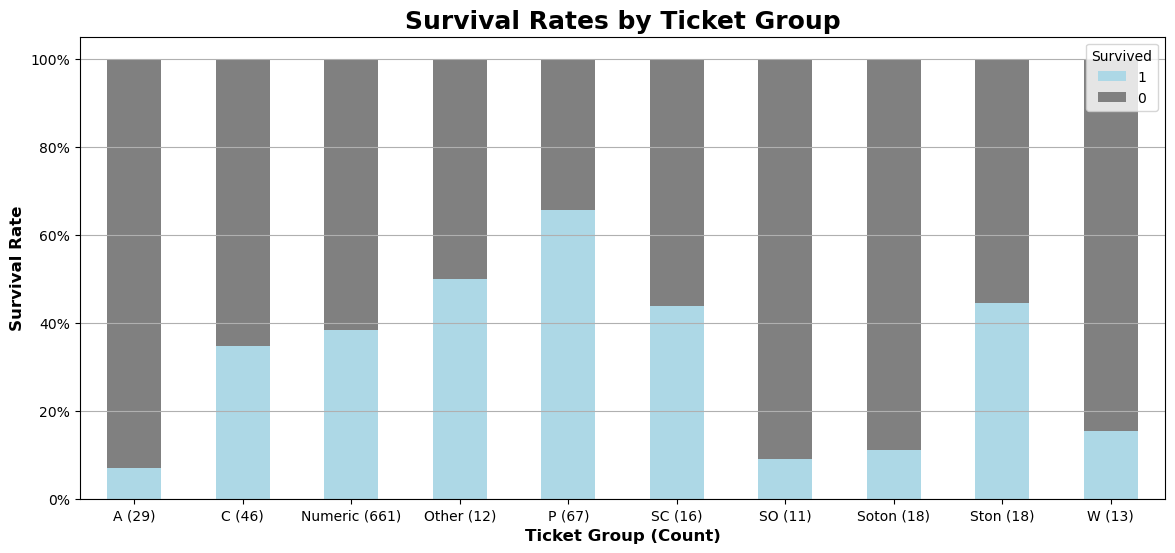

In [8]:
tickets_dict = {'A': ['A', 'A/5', 'A5', 'A/4', 'A4', 'A/S', 'AQ/3', 'AQ/4'],
                'C': ['CA', 'C'],
                'P': ['PC', 'PP', 'P/PP', 'SW/PP'],
                'SC': ['SC/PARIS', 'SC/AH', 'SC/A4', 'SC/AH BASLE', 'SC/A3', 'SCO/W'], 
                'SO': ['SOC', 'SO/PP', 'SO/C', 'SOP', 'SP'], 
                'Soton': ['SOTON/OQ', 'SOTON/O2', 'CA/SOTON'], 
                'Ston': ['STON/O', 'STON/O2', 'STON/OQ'], 
                'W': ['W/C', 'WE/P', 'WEP']}
tickets_alpha = list(itertools.chain(*[v for v in tickets_dict.values()]))

for df in df_list:
    df['TicketIsNumeric'] = [t.isnumeric() for t in df['Ticket']]    
    df['Ticket_Alpha'] = [t.upper().replace('.', '') for t in df['Ticket']]
    df['Ticket_Alpha'] = [re.sub(r' \d+', '', t) for t in df['Ticket_Alpha']]
    df['Ticket_Alpha_Group'] = ['Other' if t not in tickets_alpha else t for t in df['Ticket_Alpha']]
    df['Ticket_Group'] = 'Missing'
    df.loc[df['TicketIsNumeric'], 'Ticket_Group'] = 'Numeric'
    df.loc[df['Ticket_Group'] == 'Missing', 'Ticket_Group'] = df['Ticket_Alpha_Group']
    for d in tickets_dict:
        df['Ticket_Group'] = df['Ticket_Group'].replace(tickets_dict[d], d) 
    df.drop(['Ticket_Alpha_Group'], axis = 1, inplace = True)

surv_percent_fun('Ticket_Group', (14, 6))
train_df.head()

In [9]:
ticket_train_df = train_df[train_df['TicketIsNumeric'] == False]\
    .groupby(['Ticket_Alpha', 'Ticket_Group'], as_index = False)\
    .agg(Count = ('Ticket_Alpha', 'count'))
ticket_train_df['Set'] = 'Train'

ticket_test_df = test_df[test_df['TicketIsNumeric'] == False]\
    .groupby(['Ticket_Alpha', 'Ticket_Group'], as_index = False)\
    .agg(Count = ('Ticket_Alpha', 'count'))
ticket_test_df['Set'] = 'Test'

pd.concat([ticket_train_df, ticket_test_df])\
    .pivot(index = ['Ticket_Group', 'Ticket_Alpha'], columns = 'Set', values = 'Count')\
    .sort_values(by = ['Ticket_Group', 'Train'], ascending = False)

Set                        Test  Train
Ticket_Group Ticket_Alpha             
W            W/C            5.0   10.0
             WE/P           NaN    2.0
             WEP            1.0    1.0
Ston         STON/O         2.0   12.0
             STON/O2        1.0    6.0
             STON/OQ        1.0    NaN
Soton        SOTON/OQ       9.0   15.0
             SOTON/O2       1.0    2.0
             CA/SOTON       NaN    1.0
SO           SOC            2.0    5.0
             SO/PP          4.0    3.0
             SO/C           NaN    1.0
             SOP            NaN    1.0
             SP             NaN    1.0
SC           SC/PARIS       8.0   11.0
             SC/AH          2.0    2.0
             SC/A4          1.0    1.0
             SC/AH BASLE    NaN    1.0
             SCO/W          NaN    1.0
             SC/A3          1.0    NaN
P            PC            32.0   60.0
             PP             1.0    3.0
             P/PP           NaN    2.0
             SW/PP          NaN    2.0
Other        FCC            4.0    5.0
             LINE           NaN    4.0
             FA             NaN    1.0
             FC             2.0    1.0
             SC             1.0    1.0
             LP             1.0    NaN
C            CA            27.0   41.0
             C              3.0    5.0
A            A/5            6.0   19.0
             A/4            3.0    6.0
             A5             1.0    2.0
             A/S            NaN    1.0
             A4             NaN    1.0
             A              1.0    NaN
             AQ/3           1.0    NaN
             AQ/4           1.0    NaN

In [10]:
plot_df['Ticket_Group'] = train_df['Ticket_Group']
train_df = pd.get_dummies(train_df, columns = ['Ticket_Group'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Ticket_Group'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    df.drop(['TicketIsNumeric', 'Ticket_Alpha'], axis = 1, inplace = True)    
    for c in [c for c in df.columns if 'Ticket_Group' in c]:
        df[c] = df[c].astype(int)
    df.columns = df.columns.str.replace('Ticket_Group', 'Ticket')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,Ticket_Soton,Ticket_Ston,Ticket_W
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,1,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,1,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,1,0,0,0,0,0,0,0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,Ticket_Soton,Ticket_Ston,Ticket_W,Ticket_Freq
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,1,0,0,0,0,0,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,0,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,0,0,0,0,0,0,1


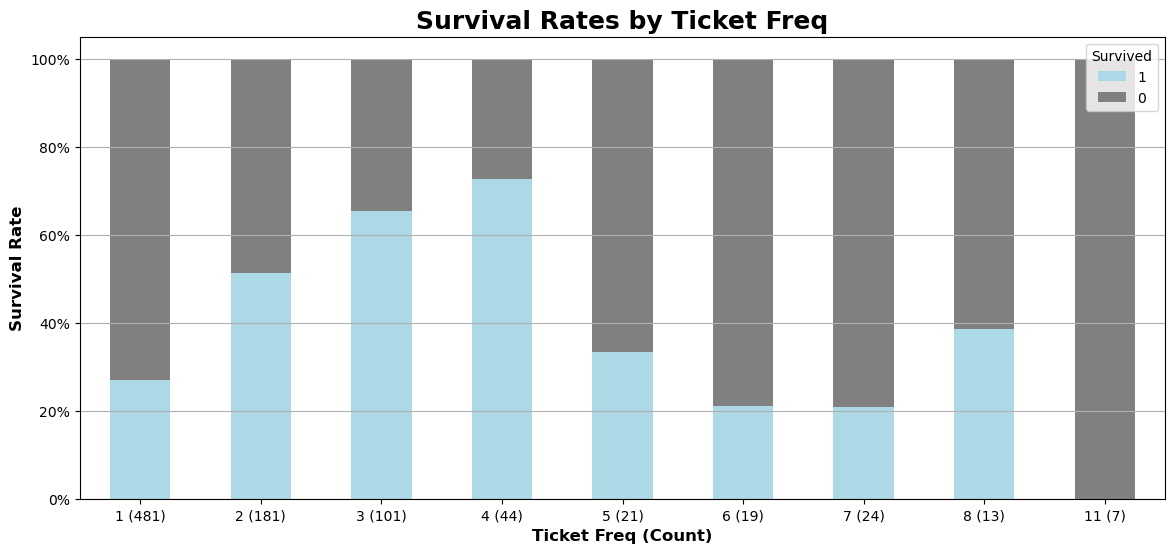

In [11]:
ticket_freq_df = pd.concat([train_df, test_df])\
        .groupby(['Ticket'], as_index = False)\
        .agg(Ticket_Freq = ('Ticket', 'count'))

for df in df_list:
    df['Ticket_Freq'] = df.merge(ticket_freq_df, on = ['Ticket'], how = 'left')['Ticket_Freq']

plot_df['Ticket_Freq'] = train_df['Ticket_Freq']

surv_percent_fun('Ticket_Freq', (14, 6))
train_df.head()

In [12]:
for df in df_list:
    df.drop(['Ticket'], axis = 1, inplace = True)

# 2.2 Name
1. Extract title from Name
2. Map titles
3. One hot encode title

In [13]:
for df in df_list:
    df['Title'] = df['Name'].str.extract(r'([A-Za-z]+)\.', expand = False)
    df.drop(['Name'], axis = 1, inplace = True)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,...,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,Ticket_Soton,Ticket_Ston,Ticket_W,Ticket_Freq,Title
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,...,0,0,0,0,0,0,0,0,1,Mr
1,2,1,1,female,38.0,1,0,71.2833,C85,C,...,0,0,1,0,0,0,0,0,2,Mrs
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,...,0,0,0,0,0,0,1,0,1,Miss
3,4,1,1,female,35.0,1,0,53.1000,C123,S,...,1,0,0,0,0,0,0,0,2,Mrs
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,...,1,0,0,0,0,0,0,0,1,Mr


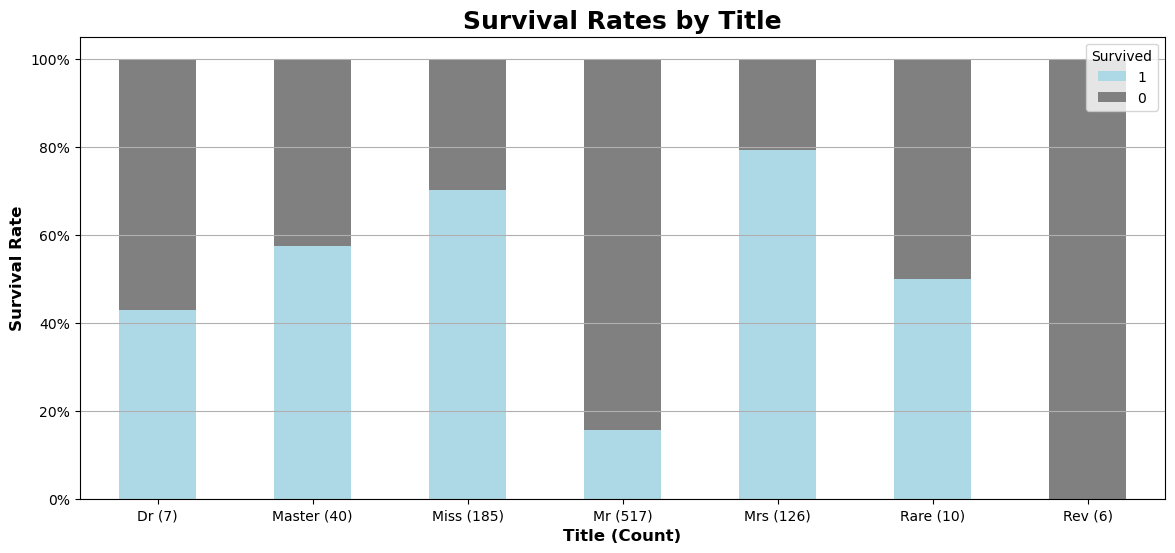

In [14]:
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Major', 'Sir', 'Jonkheer', 'Dona']

for df in df_list:
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
plot_df['Title'] = train_df['Title'] 

surv_percent_fun('Title', (14, 6))
train_df.head()

In [15]:
plot_df['Title'] = train_df['Title']
train_df = pd.get_dummies(train_df, columns = ['Title'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Title'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Title' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,...,Ticket_Ston,Ticket_W,Ticket_Freq,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_Rev
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,...,0,0,1,0,0,0,1,0,0,0
1,2,1,1,female,38.0,1,0,71.2833,C85,C,...,0,0,2,0,0,0,0,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,...,1,0,1,0,0,1,0,0,0,0
3,4,1,1,female,35.0,1,0,53.1000,C123,S,...,0,0,2,0,0,0,0,1,0,0
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,...,0,0,1,0,0,0,1,0,0,0


# 2.2 Sex
1. One hot encode sex

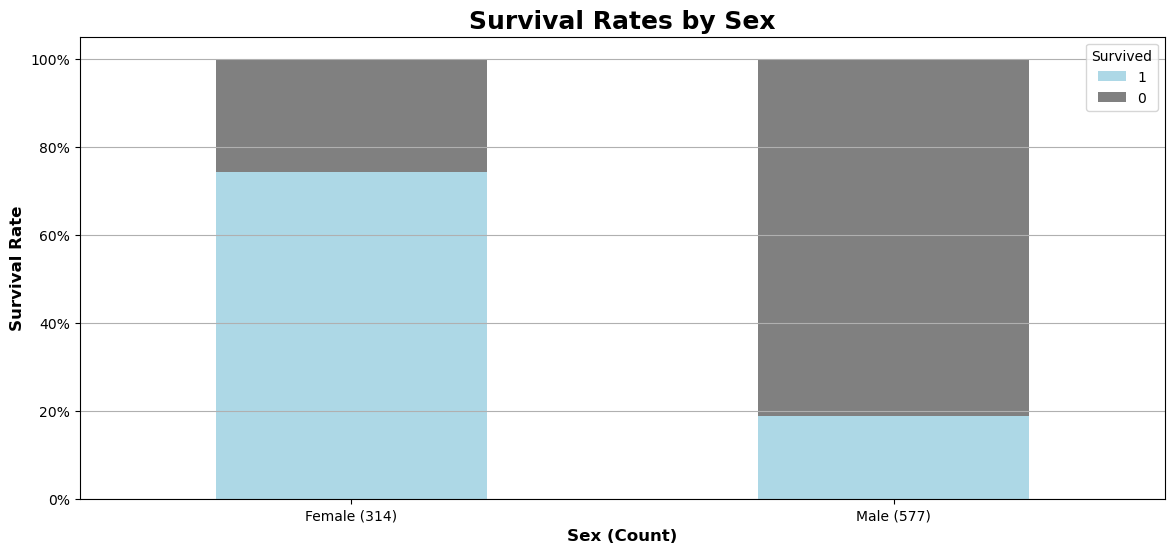

In [16]:
for df in df_list:
    df['Sex'] = df['Sex'].str.title()

surv_percent_fun('Sex', (14, 6))

In [17]:
plot_df['Sex'] = train_df['Sex']
train_df = pd.get_dummies(train_df, columns = ['Sex'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Sex'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Sex' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_A,...,Ticket_Freq,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_Rev,Sex_Female,Sex_Male
0,1,0,3,22.0,1,0,7.2500,NaN,S,1,...,1,0,0,0,1,0,0,0,0,1
1,2,1,1,38.0,1,0,71.2833,C85,C,0,...,2,0,0,0,0,1,0,0,1,0
2,3,1,3,26.0,0,0,7.9250,NaN,S,0,...,1,0,0,1,0,0,0,0,1,0
3,4,1,1,35.0,1,0,53.1000,C123,S,0,...,2,0,0,0,0,1,0,0,1,0
4,5,0,3,35.0,0,0,8.0500,NaN,S,0,...,1,0,0,0,1,0,0,0,0,1


# 2.3 Port of Embarkation
1. Impute missing with most frequent
2. Add Missing Port Indicator
3. One hot encode Embarked

Most frequent port is S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_A,...,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_Rev,Sex_Female,Sex_Male,Embarked_Missing
0,1,0,3,22.0,1,0,7.2500,NaN,S,1,...,0,0,0,1,0,0,0,0,1,0
1,2,1,1,38.0,1,0,71.2833,C85,C,0,...,0,0,0,0,1,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,NaN,S,0,...,0,0,1,0,0,0,0,1,0,0
3,4,1,1,35.0,1,0,53.1000,C123,S,0,...,0,0,0,0,1,0,0,1,0,0
4,5,0,3,35.0,0,0,8.0500,NaN,S,0,...,0,0,0,1,0,0,0,0,1,0


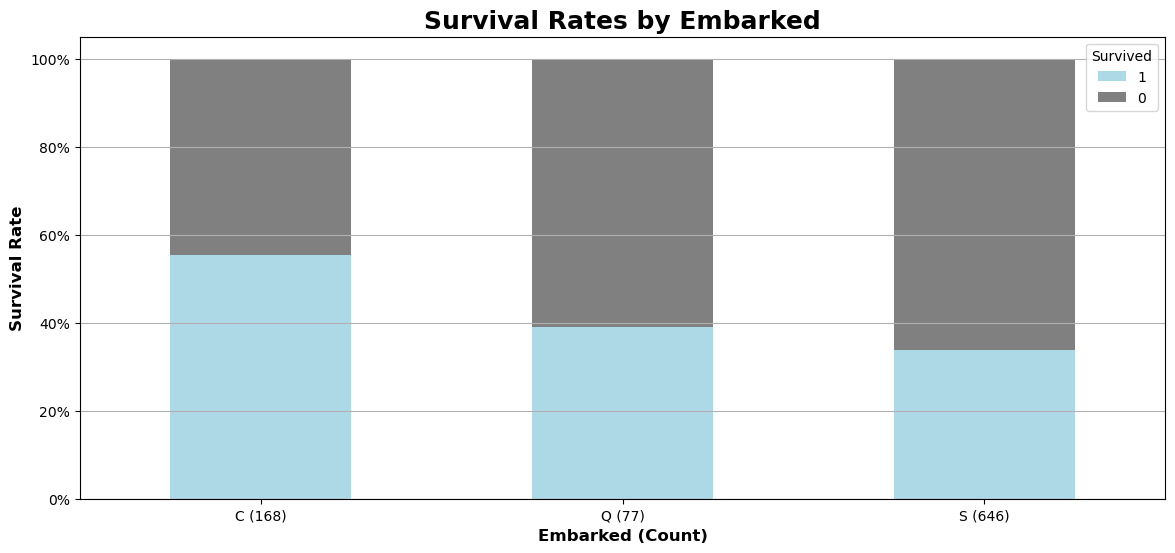

In [18]:
freq_port = train_df.Embarked.dropna().mode()[0]
print('Most frequent port is ' + freq_port)

for df in df_list:
    df.loc[df['Embarked'].isnull(), 'Embarked_Missing'] = 1
    df['Embarked_Missing'] = df['Embarked_Missing'].fillna(0).astype(int)
    df['Embarked'] = df['Embarked'].fillna(freq_port)

surv_percent_fun('Embarked', (14, 6))
train_df.head()

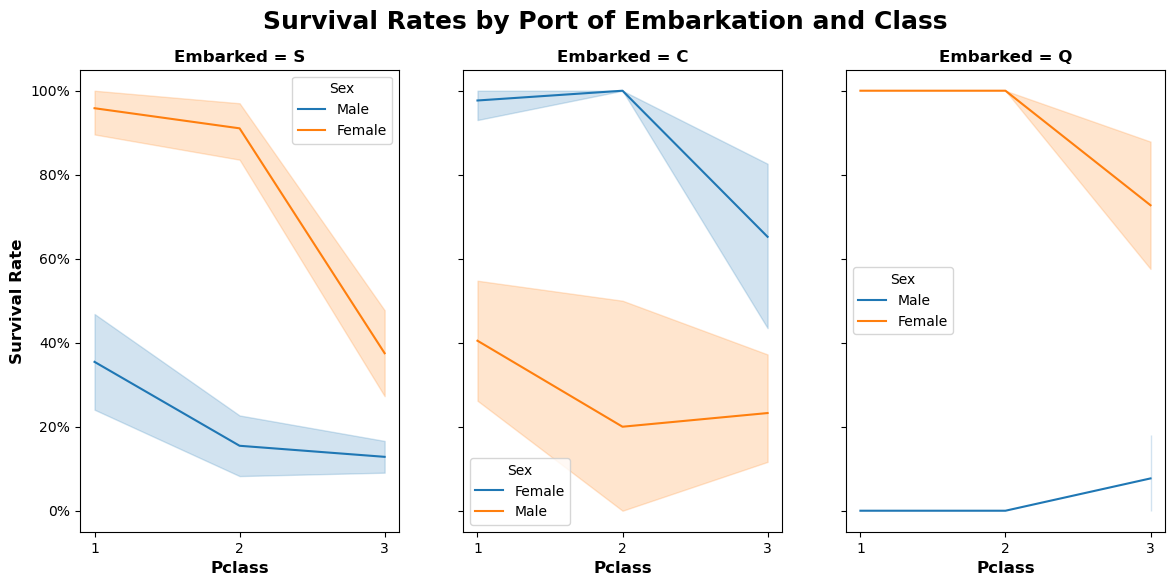

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (14, 6))

for poe, ax in zip(['S', 'C', 'Q'], [ax1, ax2, ax3]):
    sns.lineplot(x = 'Pclass', y = 'Survived', hue = 'Sex',
                 data = plot_df[plot_df['Embarked'] == poe], ax = ax)
    ax.set_xlabel('Pclass', fontdict = plot_axis_dict)
    ax.set_title("Embarked = " + poe, fontdict = plot_axis_dict)
    ax.locator_params(axis = 'x', nbins = 3)
ax1.set_ylabel('Survival Rate', fontdict = plot_axis_dict)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.suptitle('Survival Rates by Port of Embarkation and Class', 
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.show()

In [20]:
plot_df['Embarked'] = train_df['Embarked']
train_df = pd.get_dummies(train_df, columns = ['Embarked'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Embarked'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Embarked' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Ticket_A,Ticket_C,...,Title_Mr,Title_Mrs,Title_Rare,Title_Rev,Sex_Female,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,NaN,1,0,...,1,0,0,0,0,1,0,0,0,1
1,2,1,1,38.0,1,0,71.2833,C85,0,0,...,0,1,0,0,1,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,NaN,0,0,...,0,0,0,0,1,0,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,C123,0,0,...,0,1,0,0,1,0,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,NaN,0,0,...,1,0,0,0,0,1,0,0,0,1


# 3. Correlation Matrix

Decided to wait after hot encoding to better understand how to impute missing features.

Features with missing values:
1. **Age:** Correlated with Class and Titles (Master, Miss, Mr, Mrs, and Rare)
2. **Fare:** Correlated with Class, Port of Embarkation, and Ticket (P)

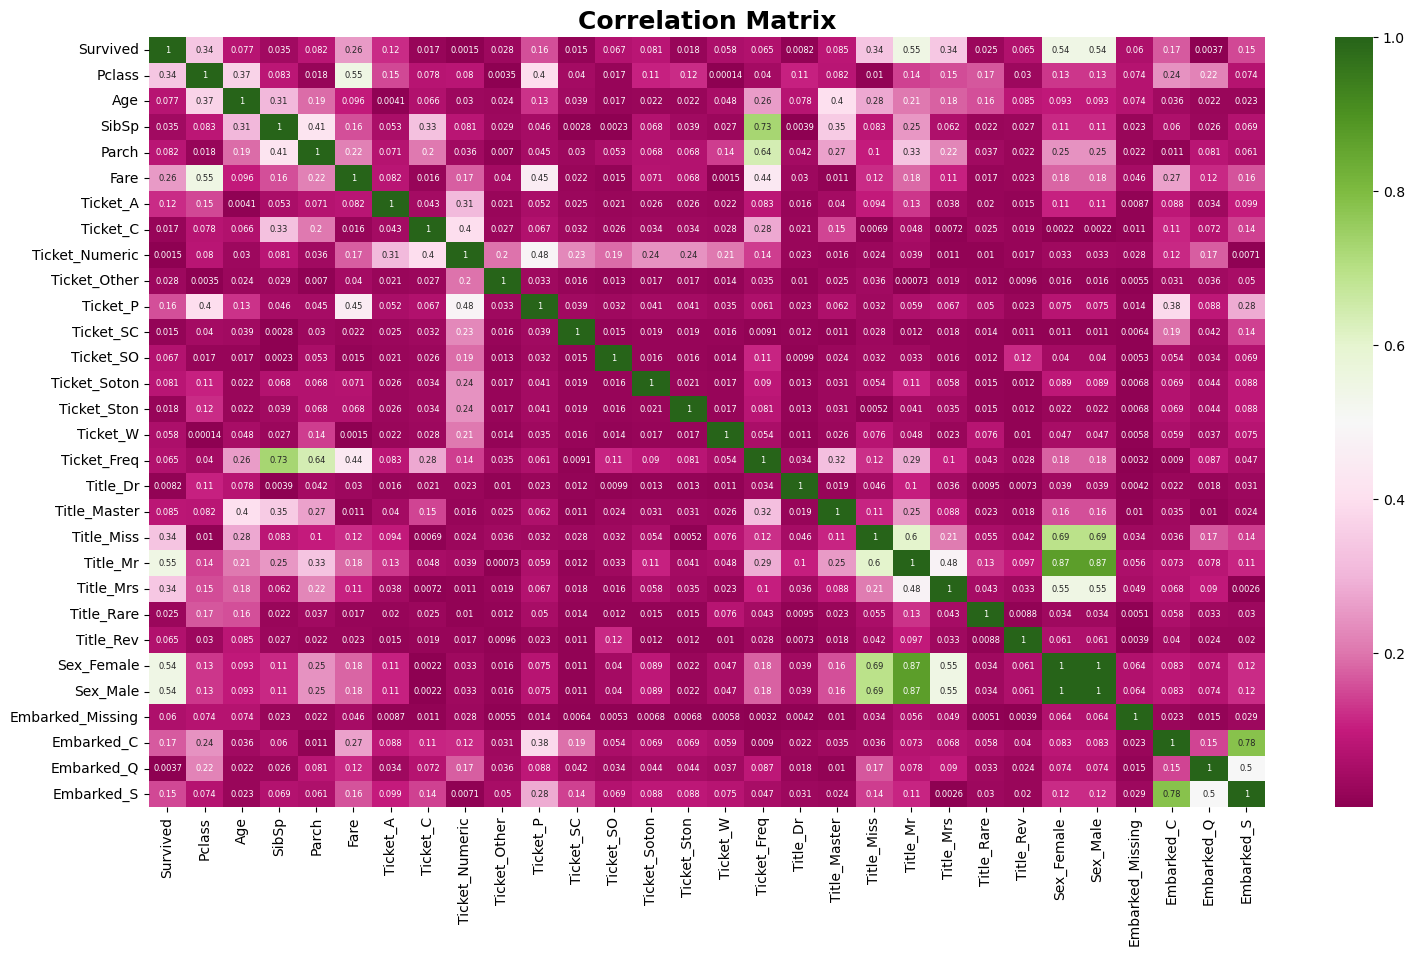

In [21]:
f, ax = plt.subplots(figsize = (18, 10))
corr_df = train_df.drop('PassengerId', axis = 1).corr(numeric_only = True).abs()
sns.heatmap(corr_df, cmap = "PiYG", annot = True, annot_kws = {"fontsize": 6})
plt.title('Correlation Matrix', fontdict = plot_title_dict)
plt.show()

# 4. Feature Engineering, Impute, Bin Features

# 4.1 Age
1. Correlated with Class and Titles (Master, Miss, Mr, Mrs, and Rare)
2. Impute based on correlation
3. Add indicator for missing ages
4. Bin Ages if model perfoms better

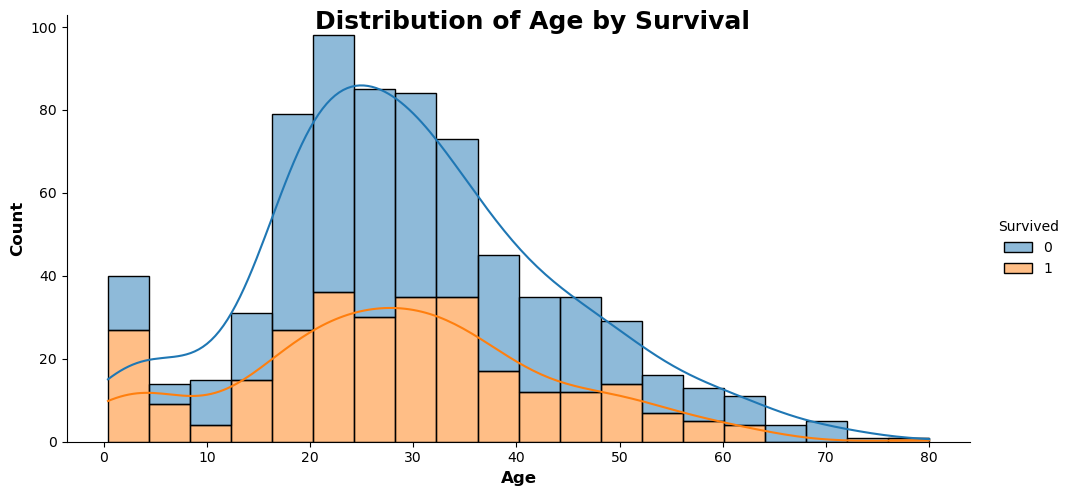

In [22]:
sns.displot(data = train_df, 
            x = 'Age', 
            hue = 'Survived', 
            kde = True,
            height = 5,
            aspect = 2,
            multiple = 'stack')
plt.suptitle('Distribution of Age by Survival',
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.ylabel('Count', fontdict = plot_axis_dict)
plt.xlabel('Age', fontdict = plot_axis_dict)
plt.show()

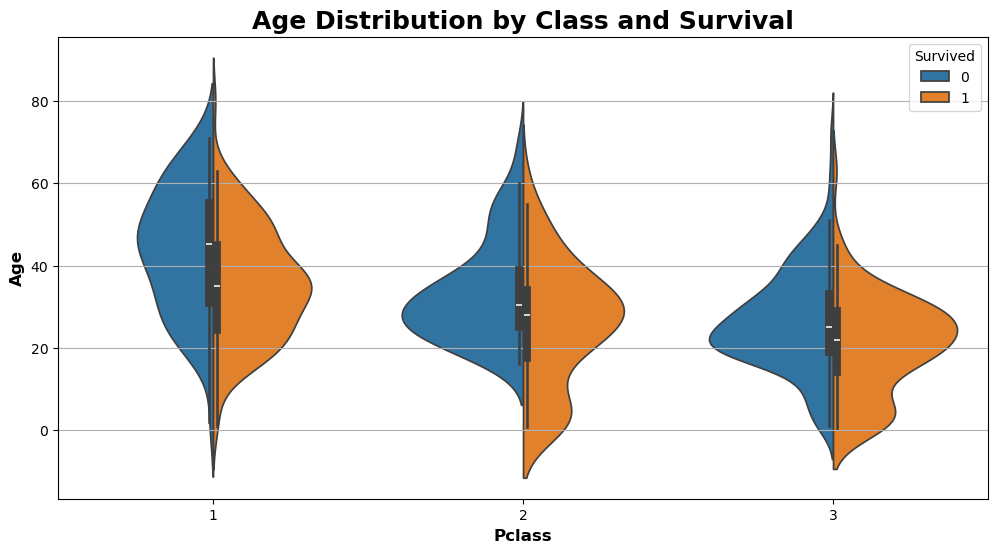

In [23]:
f, ax = plt.subplots(figsize = (12, 6))
sns.violinplot(data = plot_df, x = "Pclass", y = "Age", hue = "Survived", split = True, ax = ax)
ax.set_title('Age Distribution by Class and Survival', fontdict = plot_title_dict)
plt.ylabel('Age', fontdict = plot_axis_dict)
plt.xlabel('Pclass', fontdict = plot_axis_dict)
plt.grid(axis = 'y')
plt.show()

In [24]:
missing_age_cols = ['Pclass', 'Title_Master', 'Title_Mr', 'Title_Mrs', 'Title_Miss', 'Title_Rare']
age_missing_df = train_df[missing_age_cols + ['Age']]\
    .dropna()\
    .groupby(missing_age_cols, as_index = False)\
    .median()
age_missing_df.columns = age_missing_df.columns.str.replace('Age', 'Age_Median')
age_missing_df['Age_Median'] = age_missing_df['Age_Median'].astype(int)

age_missing_df

,Pclass,Title_Master,Title_Mr,Title_Mrs,Title_Miss,Title_Rare,Age_Median
0,1,0,0,0,0,0,46
1,1,0,0,0,0,1,48
2,1,0,0,0,1,0,30
3,1,0,0,1,0,0,40
4,1,0,1,0,0,0,40
5,1,1,0,0,0,0,4
6,2,0,0,0,0,0,46
7,2,0,0,0,1,0,24
8,2,0,0,1,0,0,32
9,2,0,1,0,0,0,31


In [25]:
for df in df_list:
    df.loc[df['Age'].isnull(), 'Age_Missing'] = 1
    df['Age_Missing'] = df['Age_Missing'].fillna(0).astype(int)
    df['Age_Median'] = df.merge(age_missing_df, on = missing_age_cols, how = 'left')['Age_Median']
    df.loc[df['Age'].isnull(), 'Age'] = df['Age_Median']
    df.drop(['Age_Median'], axis = 1, inplace = True)
    df['Age'] = df['Age'].astype(int)
plot_df['Age'] = train_df['Age']

train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Ticket_A,Ticket_C,...,Title_Mrs,Title_Rare,Title_Rev,Sex_Female,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S,Age_Missing
0,1,0,3,22,1,0,7.2500,NaN,1,0,...,0,0,0,0,1,0,0,0,1,0
1,2,1,1,38,1,0,71.2833,C85,0,0,...,1,0,0,1,0,0,1,0,0,0
2,3,1,3,26,0,0,7.9250,NaN,0,0,...,0,0,0,1,0,0,0,0,1,0
3,4,1,1,35,1,0,53.1000,C123,0,0,...,1,0,0,1,0,0,0,0,1,0
4,5,0,3,35,0,0,8.0500,NaN,0,0,...,0,0,0,0,1,0,0,0,1,0


In [26]:
# num_bins = 9
# train_df['Age_Interval'] = pd.qcut(train_df['Age'], num_bins)

# age_int_df = train_df\
#     .groupby(['Age_Interval'], as_index = False)\
#     .agg(Survived = ('Survived', 'mean'),
#          Count = ('Age_Interval', 'count'))
# age_int_df['Age'] = range(num_bins)

# fig, axs = plt.subplots(figsize = (22, 9))
# sns.countplot(x = 'Age_Interval', hue = 'Survived', data = train_df)
# plt.title('Distribution of Passengers By Age Interval and Survival')
# plt.show()

# age_int_df

In [27]:
# for df in df_list:
#     df['Age'] = [[b for i, b in zip(age_int_df['Age_Interval'], age_int_df['Age']) if a in i][0] for a in df['Age']]
# train_df.drop(['Age_Interval'], axis = 1, inplace = True)

# train_df.head()

# 4.2 Passenger Class
1. One hot encode pclass

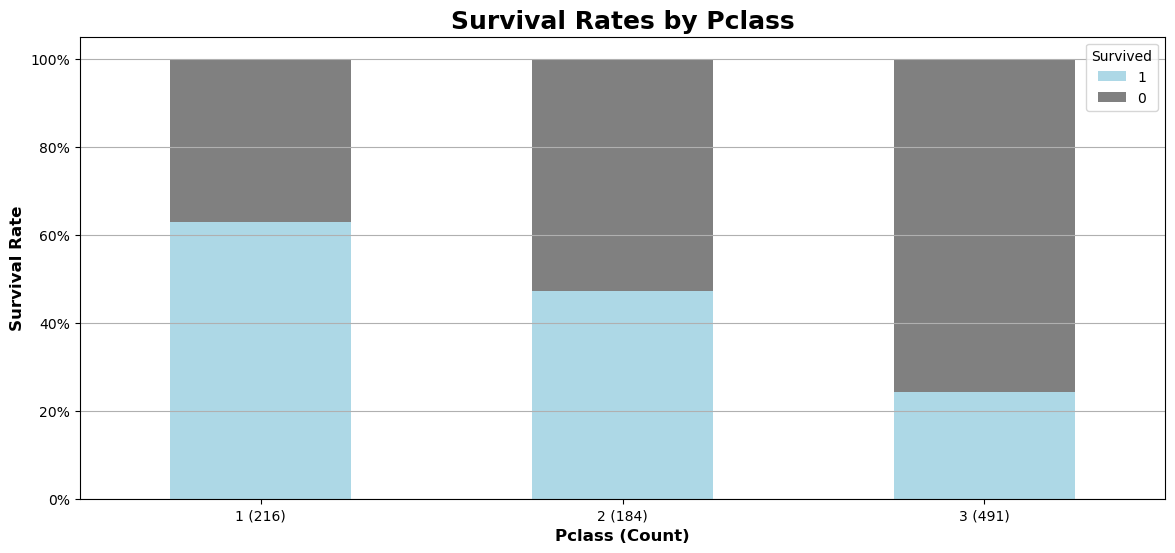

In [28]:
surv_percent_fun('Pclass', (14, 6))

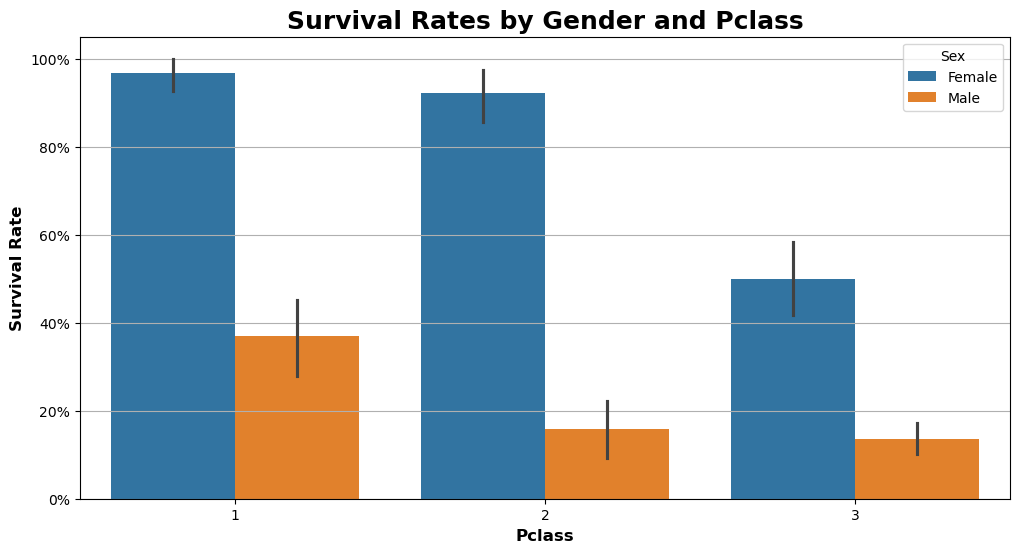

In [29]:
f, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = plot_df)
plt.title('Survival Rates by Gender and Pclass', fontdict = plot_title_dict)
plt.ylabel('Survival Rate', fontdict = plot_axis_dict)
plt.xlabel('Pclass', fontdict = plot_axis_dict)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.grid(axis = 'y')
plt.show()

In [30]:
train_df = pd.get_dummies(train_df, columns = ['Pclass'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Pclass'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Pclass' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,...,Sex_Female,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S,Age_Missing,Pclass_1,Pclass_2,Pclass_3
0,1,0,22,1,0,7.2500,NaN,1,0,0,...,0,1,0,0,0,1,0,0,0,1
1,2,1,38,1,0,71.2833,C85,0,0,0,...,1,0,0,1,0,0,0,1,0,0
2,3,1,26,0,0,7.9250,NaN,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,4,1,35,1,0,53.1000,C123,0,0,1,...,1,0,0,0,0,1,0,1,0,0
4,5,0,35,0,0,8.0500,NaN,0,0,1,...,0,1,0,0,0,1,0,0,0,1


# 4.3 Fare
1. Correlated with Class, Port of Embarkation, and Ticket (P)
2. Impute based on correlation
3. Add indicator for missing fare
4. Bin Fares if model perfoms better

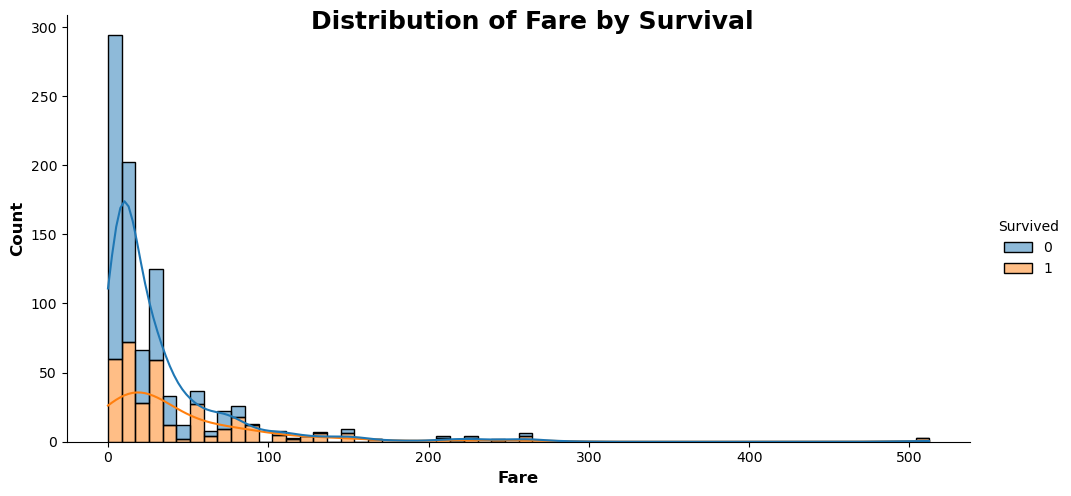

In [31]:
sns.displot(data = train_df, 
            x = 'Fare', 
            hue = 'Survived', 
            kde = True,
            height = 5,
            aspect = 2,
            multiple = 'stack')
plt.suptitle('Distribution of Fare by Survival',
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.ylabel('Count', fontdict = plot_axis_dict)
plt.xlabel('Fare', fontdict = plot_axis_dict)
plt.show()

In [32]:
missing_fare_cols = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Ticket_P']
fare_missing_df = train_df[missing_fare_cols + ['Fare']]\
    .dropna()\
    .groupby(missing_fare_cols, as_index = False)\
    .median()
fare_missing_df.columns = fare_missing_df.columns.str.replace('Fare', 'Fare_Median')

fare_missing_df

,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Ticket_P,Fare_Median
0,0,0,1,0,0,1,0,8.0500
1,0,0,1,0,0,1,1,16.7000
2,0,0,1,0,1,0,0,7.7500
3,0,0,1,1,0,0,0,7.8958
4,0,1,0,0,0,1,0,13.7500
5,0,1,0,0,0,1,1,10.5000
6,0,1,0,0,1,0,0,12.3500
7,0,1,0,1,0,0,0,27.7208
8,0,1,0,1,0,0,1,24.0000
9,1,0,0,0,0,1,0,52.5542


In [33]:
for df in df_list:
    df.loc[df['Fare'].isnull(), 'Fare_Missing'] = 1
    df['Fare_Missing'] = df['Fare_Missing'].fillna(0).astype(int)
    df['Fare_Median'] = df.merge(fare_missing_df, on = missing_fare_cols, how = 'left')['Fare_Median']
    df.loc[df['Fare'].isnull(), 'Fare'] = df['Fare_Median']
    df.drop(['Fare_Median'], axis = 1, inplace = True)

plot_df['Fare'] = train_df['Fare']

train_df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,...,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S,Age_Missing,Pclass_1,Pclass_2,Pclass_3,Fare_Missing
0,1,0,22,1,0,7.2500,NaN,1,0,0,...,1,0,0,0,1,0,0,0,1,0
1,2,1,38,1,0,71.2833,C85,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,3,1,26,0,0,7.9250,NaN,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,4,1,35,1,0,53.1000,C123,0,0,1,...,0,0,0,0,1,0,1,0,0,0
4,5,0,35,0,0,8.0500,NaN,0,0,1,...,1,0,0,0,1,0,0,0,1,0


In [34]:
# for df in df_list:
#     df['Fare_Log'] = np.log(df['Fare'])
#     df.loc[df['Fare_Log'].isin([np.inf, -np.inf]), 'Fare_Log'] = 0
#     df.drop(['Fare'], axis = 1, inplace = True)

# plot_df['Fare_Log'] = train_df['Fare_Log']

# train_df.head()

In [35]:
# sns.displot(data = train_df, 
#             x = 'Fare_Log', 
#             hue = 'Survived', 
#             kde = True,
#             height = 5,
#             aspect = 2,
#             multiple = 'stack')
# plt.suptitle('Distribution of Fare (Log) by Survival')
# plt.show()

In [36]:
# num_bins = 10
# train_df['Fare_Interval'] = pd.qcut(train_df['Fare'], num_bins, precision = 4)

# fare_int_df = train_df\
#     .groupby(['Fare_Interval'], as_index = False)\
#     .agg(Survived = ('Survived', 'mean'),
#          Count = ('Fare_Interval', 'count'))
# fare_int_df['Fare'] = range(num_bins)

# fig, axs = plt.subplots(figsize = (22, 9))
# sns.countplot(x = 'Fare_Interval', hue = 'Survived', data = train_df)
# plt.title('Distribution of Passengers By Fare Interval and Survival')
# plt.show()

# fare_int_df

In [37]:
# for df in df_list:
#     df['Fare'] = [[b for i, b in zip(fare_int_df['Fare_Interval'], fare_int_df['Fare']) if a in i][0] for a in df['Fare']]
# train_df.drop(['Fare_Interval'], axis = 1, inplace = True)

# train_df.head()

# 4.4 Family Size = SibSp + Parch
1. Create Family Size
2. Drop SibSp, and Parch
3. Bin Fares if model perfoms better

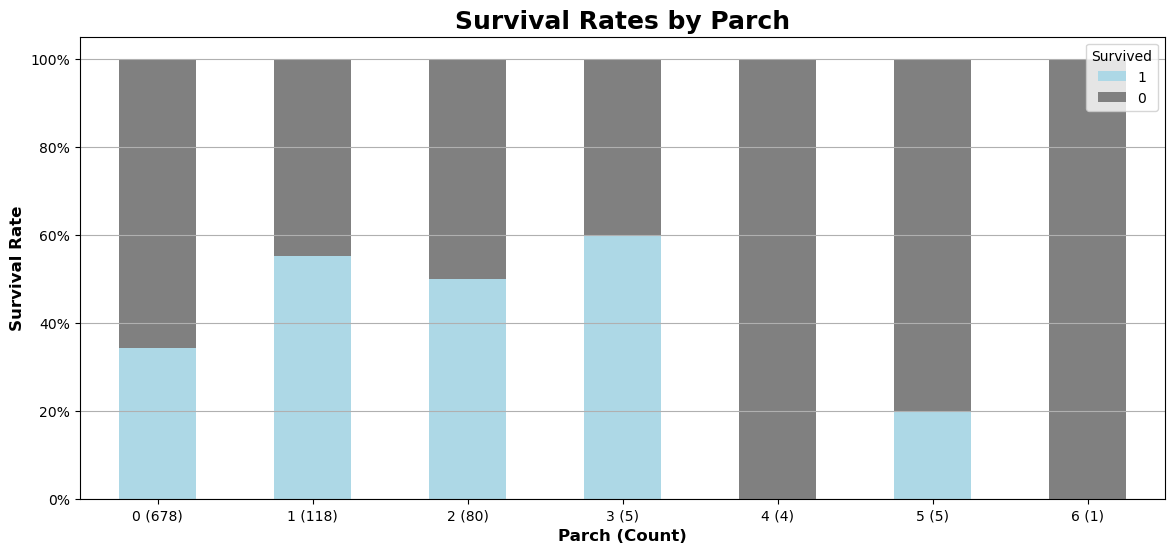

In [38]:
surv_percent_fun('Parch', (14, 6))

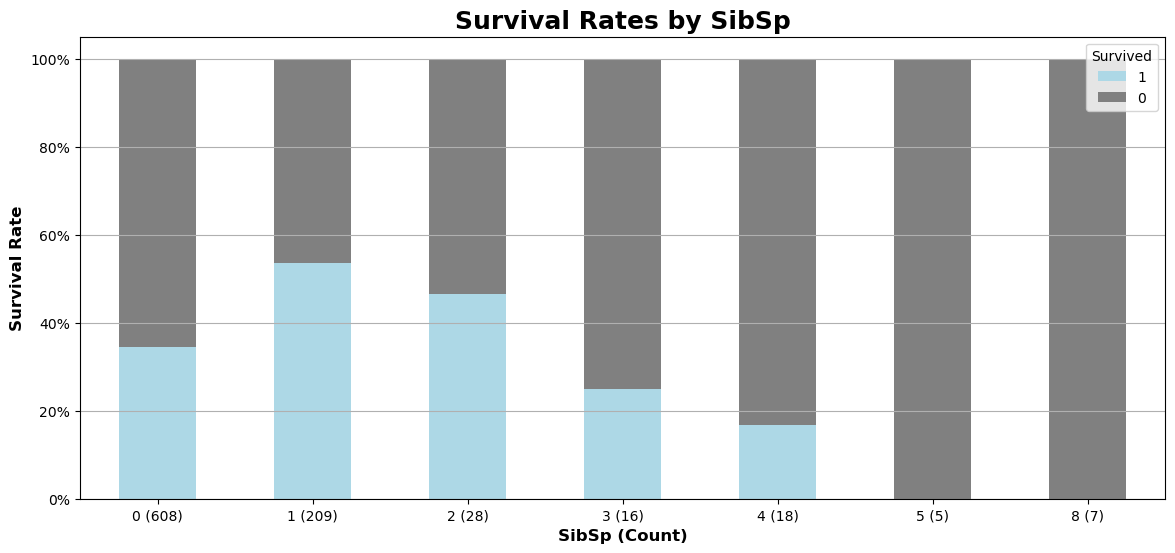

In [39]:
surv_percent_fun('SibSp', (14, 6))

,PassengerId,Survived,Age,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,...,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S,Age_Missing,Pclass_1,Pclass_2,Pclass_3,Fare_Missing,FamilySize
0,1,0,22,7.2500,NaN,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,2
1,2,1,38,71.2833,C85,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,2
2,3,1,26,7.9250,NaN,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
3,4,1,35,53.1000,C123,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,2
4,5,0,35,8.0500,NaN,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1


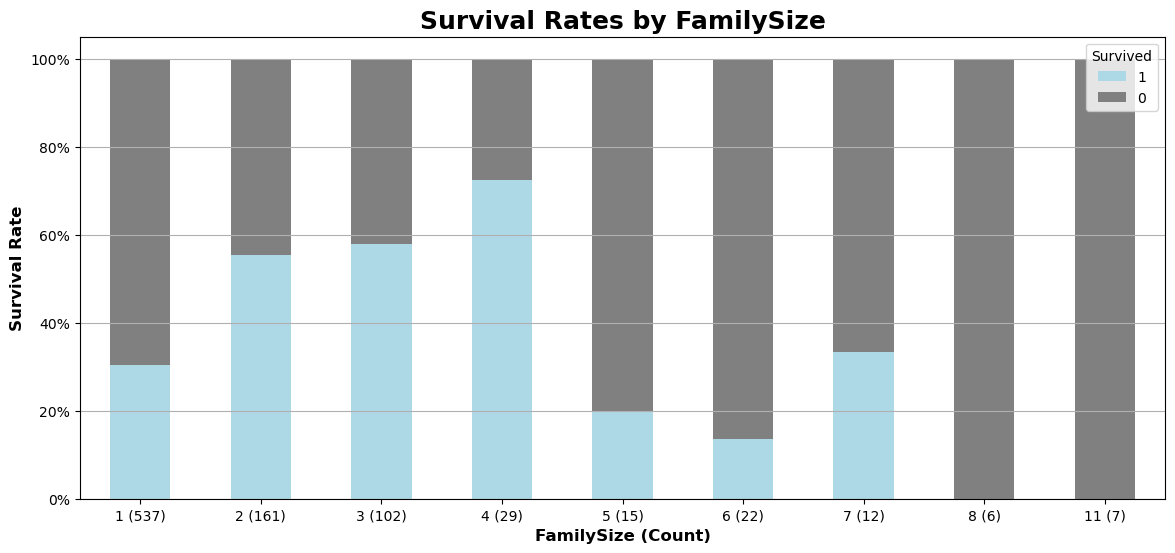

In [40]:
for df in df_list:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df.drop(['Parch', 'SibSp'], axis = 1, inplace = True)

plot_df['FamilySize'] = train_df['FamilySize']

surv_percent_fun('FamilySize', (14, 6))
train_df.head()

In [41]:
# for df in df_list:    
#     df.loc[ df['FamilySize'] <= 1, 'FamilySizeBin'] = 'Alone'
#     df.loc[(df['FamilySize'] > 1) & (df['FamilySize'] <= 4), 'FamilySizeBin'] = 'Small'
#     df.loc[(df['FamilySize'] > 4) & (df['FamilySize'] <= 6), 'FamilySizeBin'] = 'Medium'
#     df.loc[df['FamilySize'] > 6, 'FamilySizeBin'] = 'Large'
#     df.drop(['FamilySize'], axis = 1, inplace = True)
    
# train_df.head()

In [42]:
# f, ax = plt.subplots(figsize = (12, 6))
# sns.barplot(x = 'FamilySizeBin', y = 'Survived', data = train_df)
# plt.title('Survival Rates by Family Size')
# plt.show()

In [43]:
# train_df = pd.get_dummies(train_df, columns = ['FamilySizeBin'], drop_first = False)
# test_df = pd.get_dummies(test_df, columns = ['FamilySizeBin'], drop_first = False)
# df_list = [train_df, test_df]

# for df in df_list:
#     for c in [c for c in df.columns if 'FamilySizeBin' in c]:
#         df[c] = df[c].astype(int)
#     df.columns = df.columns.str.replace('FamilySizeBin', 'Fam_Size')

# train_df.head()

# 4.5 Cabin
1. Extract Deck from Cabin: First Cabin letter is the Deck
2. Do not impute missing cabin; group together as Deck X
3. Drop Cabin

,PassengerId,Survived,Age,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,...,Embarked_C,Embarked_Q,Embarked_S,Age_Missing,Pclass_1,Pclass_2,Pclass_3,Fare_Missing,FamilySize,Deck
0,1,0,22,7.2500,NaN,1,0,0,0,0,...,0,0,1,0,0,0,1,0,2,X
1,2,1,38,71.2833,C85,0,0,0,0,1,...,1,0,0,0,1,0,0,0,2,C
2,3,1,26,7.9250,NaN,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,X
3,4,1,35,53.1000,C123,0,0,1,0,0,...,0,0,1,0,1,0,0,0,2,C
4,5,0,35,8.0500,NaN,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,X


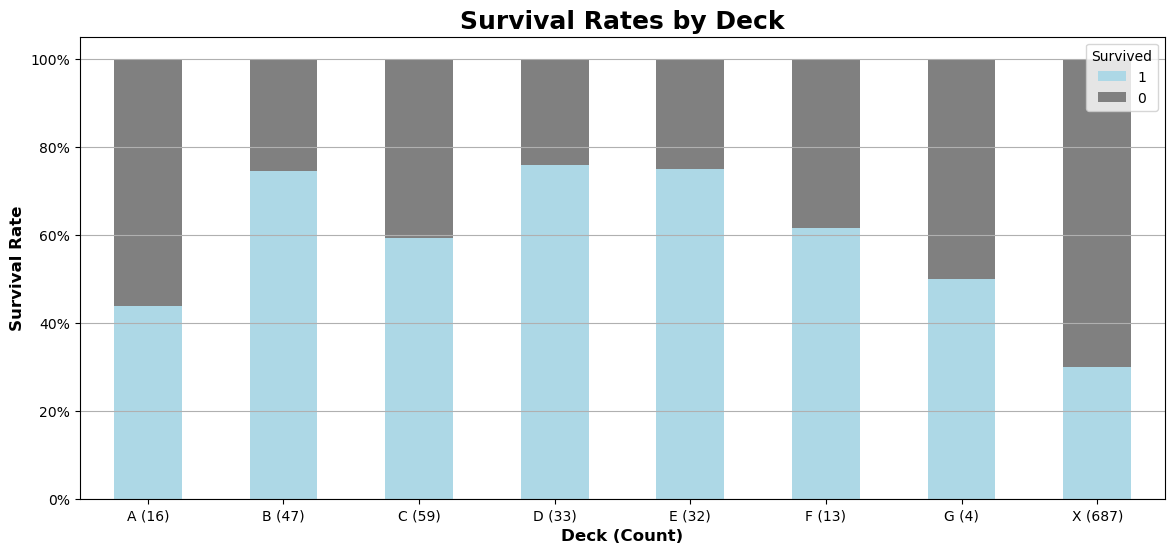

In [44]:
for df in df_list:
    df['Deck'] = [re.sub(r'\d+', '', c.split()[0])for c in df['Cabin'].fillna('X')]
    df.loc[df['Deck'] == 'T', 'Deck'] = 'A'

surv_percent_fun('Deck', (14, 6))
train_df.head()

In [45]:
plot_df['Deck'] = train_df['Deck']
train_df = pd.get_dummies(train_df, columns = ['Deck'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Deck'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Deck' in c]:
        df[c] = df[c].astype(int)
    df.drop(['Cabin'], axis = 1, inplace = True)

train_df.head()

,PassengerId,Survived,Age,Fare,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,...,Fare_Missing,FamilySize,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X
0,1,0,22,7.2500,1,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
1,2,1,38,71.2833,0,0,0,0,1,0,...,0,2,0,0,1,0,0,0,0,0
2,3,1,26,7.9250,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,4,1,35,53.1000,0,0,1,0,0,0,...,0,2,0,0,1,0,0,0,0,0
4,5,0,35,8.0500,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


# 4.6 Passenger ID
1. Drop from training set

In [46]:
train_df.drop(['PassengerId'], axis = 1, inplace = True)

train_df.head()

,Survived,Age,Fare,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,...,Fare_Missing,FamilySize,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X
0,0,22,7.2500,1,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
1,1,38,71.2833,0,0,0,0,1,0,0,...,0,2,0,0,1,0,0,0,0,0
2,1,26,7.9250,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1,35,53.1000,0,0,1,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
4,0,35,8.0500,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


# 5. Add Interactions

Explore interactions between Fare, Age, and Family Size

In [47]:
for df in df_list:
    # df['FS*Fare'] = df['FamilySize'] * df['Fare']
    # df['FS*Age'] = df['FamilySize'] * df['Age']
    df['Female*Age'] = df['Sex_Female'] * df['Age']
    df['Male*Fare'] = df['Sex_Male'] * df['Fare']
    df['Fare*Age'] = df['Fare'] * df['Age']
    
train_df.head()

,Survived,Age,Fare,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X,Female*Age,Male*Fare,Fare*Age
0,0,22,7.2500,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,7.25,159.5000
1,1,38,71.2833,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,38,0.00,2708.7654
2,1,26,7.9250,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,26,0.00,206.0500
3,1,35,53.1000,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,35,0.00,1858.5000
4,0,35,8.0500,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,8.05,281.7500


# 6. Score Models
1. Final check for missing features
2. Scale features
3. Train candidate models and store in dictionary
4. Rank candidate models by cross-validated accuracy 

**Candidate Models:**
1. Logistic Regression
2. Support Vector Machines
3. KNN
4. Naive Bayes
5. Perceptron
6. Linear SVC
7. Stochastic Gradient Decent
8. Decision Tree
9. Random Forest

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
import xgboost as xgb
from xgboost import XGBClassifier

In [49]:
pd.concat([train_df, test_df]).isnull().sum().sort_values(ascending = False)

PassengerId         891
Survived            418
Fare                  0
Deck_B                0
Embarked_S            0
Age_Missing           0
Pclass_1              0
Pclass_2              0
Pclass_3              0
Fare_Missing          0
FamilySize            0
Deck_A                0
Deck_C                0
Embarked_C            0
Deck_D                0
Deck_E                0
Deck_F                0
Deck_G                0
Deck_X                0
Female*Age            0
Male*Fare             0
Fare*Age              0
Embarked_Q            0
Embarked_Missing      0
Ticket_A              0
Ticket_W              0
Ticket_C              0
Ticket_Numeric        0
Ticket_Other          0
Ticket_P              0
Ticket_SC             0
Ticket_SO             0
Ticket_Soton          0
Ticket_Ston           0
Ticket_Freq           0
Age                   0
Title_Dr              0
Title_Master          0
Title_Miss            0
Title_Mr              0
Title_Mrs             0
Title_Rare      

In [50]:
# Split X, Y
X_train = train_df.drop("Survived", axis = 1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis = 1).copy()

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
logreg = LogisticRegression()
svc = SVC(probability = True)
knn = KNeighborsClassifier(n_neighbors = 3)
gaussian = GaussianNB()
perceptron = Perceptron()
linear_svc = LinearSVC()
sgd = SGDClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators = 100)
xgb_boost = XGBClassifier(n_estimators = 100)

model_dict = {'Logistic Regression': {'Model': logreg, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Support Vector Machines': {'Model': svc, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'KNN': {'Model': knn, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Naive Bayes': {'Model': gaussian, 'X_Train': X_train, 'X_Test': X_test},
              'Perceptron': {'Model': perceptron, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Linear SVC': {'Model': linear_svc, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Stochastic Gradient Decent': {'Model': sgd, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Decision Tree': {'Model': decision_tree, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Random Forest': {'Model': random_forest, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'XGBoost': {'Model': xgb_boost, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled}}

In [52]:
models_df = pd.DataFrame()

for d in model_dict:
    print('Training ' + d)
    
    # Fit Models
    model_dict[d]['Model'].fit(model_dict[d]['X_Train'], Y_train)
    
    # Store Probabilities (not all models support predict_proba)
    # Only need this in case model is later included in ensemble
    if d not in ['Perceptron', 'Linear SVC', 'Stochastic Gradient Decent']:        
        model_dict[d]['CV_Prob'] = cross_val_predict(model_dict[d]['Model'],
                                                     model_dict[d]['X_Train'],
                                                     Y_train,
                                                     cv = 10,
                                                     method = 'predict_proba')[:,1]
        model_dict[d]['Train_Prob'] = model_dict[d]['Model'].predict_proba(model_dict[d]['X_Train'])[:,1]
        model_dict[d]['Test_Prob'] = model_dict[d]['Model'].predict_proba(model_dict[d]['X_Test'])[:,1]
    
    # Calculate CV Accuracy and AUC
    cv_scores_acc = cross_val_score(model_dict[d]['Model'], 
                                    model_dict[d]['X_Train'],
                                    Y_train, 
                                    cv = 10, 
                                    scoring = "accuracy")
    cv_scores_auc = cross_val_score(model_dict[d]['Model'], 
                                    model_dict[d]['X_Train'],
                                    Y_train, 
                                    cv = 10, 
                                    scoring = "roc_auc")
    model_score = model_dict[d]['Model'].score(model_dict[d]['X_Train'], Y_train)

    # Append metrics
    df = pd.DataFrame({'Model': [d],
                       'Score': [round(model_score * 100, 2)],
                       'CV_Accuracy_Mean': [round(cv_scores_acc.mean() * 100, 2)],
                       'CV_Accuracy_SD': [round(cv_scores_acc.std() * 100, 2)],
                       'CV_ROC_AUC_Mean': [round(cv_scores_auc.mean() * 100, 2)],
                       'CV_ROC_AUC_SD': [round(cv_scores_auc.std() * 100, 2)]})
    models_df = pd.concat([models_df, df]).reset_index(drop = True)

models_df.sort_values(by = 'CV_Accuracy_Mean', ascending = False)

Training Logistic Regression
Training Support Vector Machines
Training KNN
Training Naive Bayes
Training Perceptron
Training Linear SVC
Training Stochastic Gradient Decent
Training Decision Tree
Training Random Forest
Training XGBoost


,Model,Score,CV_Accuracy_Mean,CV_Accuracy_SD,CV_ROC_AUC_Mean,CV_ROC_AUC_SD
1,Support Vector Machines,87.09,83.39,3.23,86.88,6.15
0,Logistic Regression,84.51,83.17,3.20,86.87,5.09
5,Linear SVC,84.40,83.05,3.49,86.70,5.12
8,Random Forest,99.21,82.72,4.12,87.40,5.72
9,XGBoost,98.54,81.26,4.00,86.05,6.21
2,KNN,88.44,80.14,3.31,83.03,4.58
7,Decision Tree,99.21,78.57,3.13,76.74,3.79
3,Naive Bayes,79.24,77.55,3.86,82.45,4.74
6,Stochastic Gradient Decent,79.01,76.43,2.62,80.14,5.68
4,Perceptron,79.57,71.94,5.80,75.90,5.51


In [53]:
if kaggle_env == False:
    print(pd.read_pickle(kaggle_path + '/baseline/baseline').sort_values(by = 'CV_Accuracy_Mean', ascending = False))

                        Model  Score  CV_Accuracy_Mean  CV_Accuracy_SD  \
1     Support Vector Machines  87.09             83.39            3.23   
0         Logistic Regression  84.51             83.17            3.20   
5                  Linear SVC  84.40             83.05            3.49   
8               Random Forest  99.21             82.27            5.14   
9                     XGBoost  98.54             81.26            4.00   
2                         KNN  88.44             80.14            3.31   
7               Decision Tree  99.21             78.79            2.90   
3                 Naive Bayes  79.24             77.55            3.86   
6  Stochastic Gradient Decent  81.37             75.09            5.78   
4                  Perceptron  79.57             71.94            5.80   

   CV_ROC_AUC_Mean  CV_ROC_AUC_SD  
1            86.88           6.15  
0            86.87           5.09  
5            86.70           5.12  
8            87.64           5.62  
9    

In [54]:
# # Save as baseline if results favorable
# models_df.to_pickle(kaggle_path + '/baseline/baseline')

# 7. Tune Hyper Parameters

1. Create model objective function with paramater space
2. Create and run the optimization process with 100 trials
3. Retrieve the best parameter values and fine tune model
4. Train model with best parameter and store in dictionary
5. Evaluate feature importance

References:

1. https://www.youtube.com/watch?v=D9xPjkOwpNk

In [55]:
import optuna

/Users/andressanchez/micromamba/envs/anfield_west/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 7.1 Random Forest Hyper Parameter Tuning

In [56]:
model_dict['Random Forest Hyper Tuned'] = {'X_Train': X_train_scaled, 'X_Test': X_test_scaled}

In [57]:
def rf_obj_fun(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
    }

    model = RandomForestClassifier(**param,)
    score = cross_val_score(model, 
                            model_dict['Random Forest Hyper Tuned']['X_Train'], 
                            Y_train, cv = 3, 
                            scoring = "roc_auc").mean()
    return score

rf_study = optuna.create_study(study_name = 'rf_study_cpu', direction = "maximize")
rf_study.optimize(rf_obj_fun,
                  n_trials = 10,
                  show_progress_bar = True,
                  n_jobs = -1)

[I 2025-11-29 20:41:59,623] A new study created in memory with name: rf_study_cpu
Best trial: 3. Best value: 0.873638:  10%|▋      | 1/10 [00:04<00:38,  4.32s/it]

[I 2025-11-29 20:42:03,939] Trial 3 finished with value: 0.8736378742849839 and parameters: {'n_estimators': 161, 'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8736378742849839.


Best trial: 9. Best value: 0.875499:  20%|█▍     | 2/10 [00:07<00:27,  3.46s/it]

[I 2025-11-29 20:42:06,801] Trial 9 finished with value: 0.8754993129453871 and parameters: {'n_estimators': 295, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 9 with value: 0.8754993129453871.


Best trial: 9. Best value: 0.875499:  30%|██     | 3/10 [00:11<00:25,  3.67s/it]

[I 2025-11-29 20:42:10,724] Trial 0 finished with value: 0.8708017767551848 and parameters: {'n_estimators': 526, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 9 with value: 0.8754993129453871.


Best trial: 9. Best value: 0.875499:  40%|██▊    | 4/10 [00:13<00:18,  3.11s/it]

[I 2025-11-29 20:42:12,963] Trial 6 finished with value: 0.8744447640047296 and parameters: {'n_estimators': 647, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.8754993129453871.


Best trial: 9. Best value: 0.875499:  50%|███▌   | 5/10 [00:14<00:11,  2.26s/it]

[I 2025-11-29 20:42:13,730] Trial 1 finished with value: 0.8666474930495638 and parameters: {'n_estimators': 721, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 9 with value: 0.8754993129453871.


Best trial: 9. Best value: 0.875499:  80%|█████▌ | 8/10 [00:15<00:03,  1.83s/it]

[I 2025-11-29 20:42:14,724] Trial 8 finished with value: 0.8750758955676988 and parameters: {'n_estimators': 820, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.8754993129453871.
[I 2025-11-29 20:42:14,750] Trial 5 finished with value: 0.8673185696481642 and parameters: {'n_estimators': 841, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 10}. Best is trial 9 with value: 0.8754993129453871.
[I 2025-11-29 20:42:14,785] Trial 4 finished with value: 0.871297095197009 and parameters: {'n_estimators': 834, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 9 with value: 0.8754993129453871.
[I 2025-11-29 20:42:14,815] Trial 2 finished with value: 0.86755823986195 and parameters: {'n_estimators': 876, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.8754993129453871.


Best trial: 7. Best value: 0.875803: 100%|██████| 10/10 [00:15<00:00,  1.53s/it]

[I 2025-11-29 20:42:14,975] Trial 7 finished with value: 0.8758028952161826 and parameters: {'n_estimators': 951, 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8758028952161826.


In [58]:
rf_best_params = rf_study.best_params
print(f"\nBest parameters: {rf_best_params}")


Best parameters: {'n_estimators': 951, 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 3}


In [59]:
rf_tuned = RandomForestClassifier(n_estimators = rf_best_params['n_estimators'],
                                  max_depth = rf_best_params['max_depth'],
                                  min_samples_split = rf_best_params['min_samples_split'],
                                  min_samples_leaf = rf_best_params['min_samples_leaf'])
rf_tuned.fit(model_dict['Random Forest Hyper Tuned']['X_Train'], Y_train)
model_dict['Random Forest Hyper Tuned']['Model'] = rf_tuned

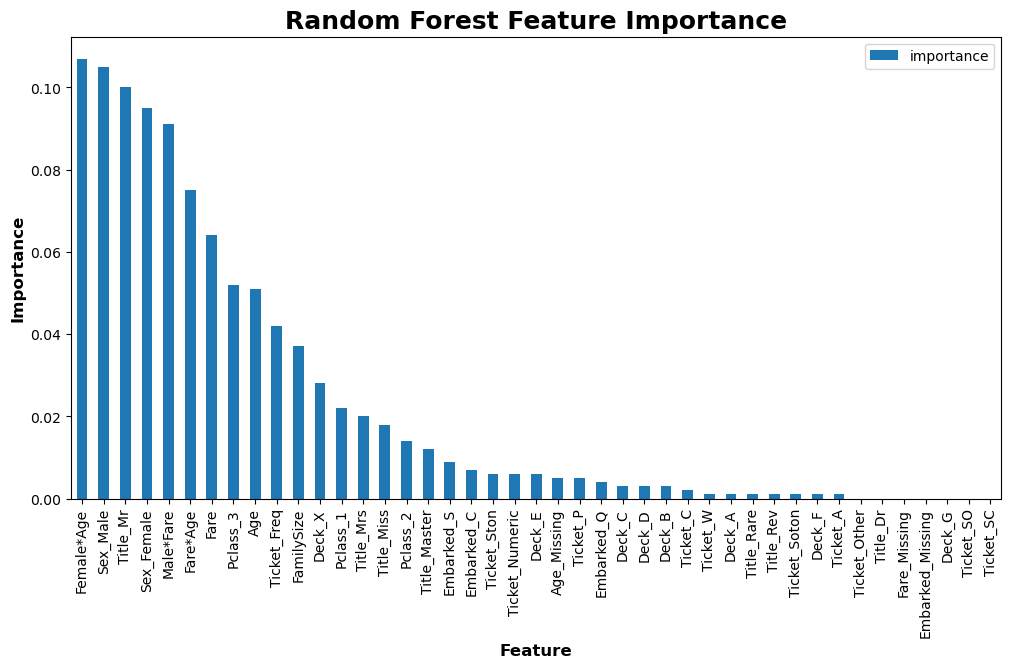

In [60]:
rf_feature_imp = pd.DataFrame({'feature': X_train.columns, 
                               'importance': np.round(model_dict['Random Forest Hyper Tuned']['Model'].feature_importances_,3)})
rf_feature_imp = rf_feature_imp.sort_values('importance', ascending = False).set_index('feature')

f, ax = plt.subplots(figsize = (12, 6))
rf_feature_imp.plot.bar(ax = ax)
plt.title('Random Forest Feature Importance', fontdict = plot_title_dict)
plt.ylabel('Importance', fontdict = plot_axis_dict)
plt.xlabel('Feature', fontdict = plot_axis_dict)
plt.show()

# 7.2 XGBoost Hyper Parameter Tuning

In [61]:
model_dict['XGBoost Hyper Tuned'] = {'X_Train': X_train_scaled, 'X_Test': X_test_scaled}

In [62]:
def xgb_obj_fun(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
    }
    
    model = xgb.XGBClassifier(**param)
    score = cross_val_score(model, 
                            model_dict['XGBoost Hyper Tuned']['X_Train'], 
                            Y_train, cv = 3, 
                            scoring = "roc_auc").mean()
    return score

xgb_study = optuna.create_study(study_name = 'xgboost_study_cpu', direction = "maximize")
xgb_study.optimize(xgb_obj_fun,
                   n_trials = 10,
                   show_progress_bar = True,
                   n_jobs = -1)

[I 2025-11-29 20:42:15,969] A new study created in memory with name: xgboost_study_cpu
Best trial: 0. Best value: 0.871784:  10%|▋      | 1/10 [00:17<02:37, 17.48s/it]

[I 2025-11-29 20:42:33,447] Trial 0 finished with value: 0.8717844246317069 and parameters: {'max_depth': 6, 'learning_rate': 0.0683131739182731, 'n_estimators': 340, 'subsample': 0.7333882081112005, 'colsample_bytree': 0.8314091380369473, 'min_child_weight': 10, 'gamma': 3.210576426751712}. Best is trial 0 with value: 0.8717844246317069.


Best trial: 4. Best value: 0.878264:  20%|█▍     | 2/10 [00:18<01:04,  8.02s/it]

[I 2025-11-29 20:42:34,852] Trial 4 finished with value: 0.8782635094110504 and parameters: {'max_depth': 5, 'learning_rate': 0.029336268969422853, 'n_estimators': 142, 'subsample': 0.7852624630171259, 'colsample_bytree': 0.5136882207055613, 'min_child_weight': 5, 'gamma': 1.2874416988627413}. Best is trial 4 with value: 0.8782635094110504.


Best trial: 4. Best value: 0.878264:  30%|██     | 3/10 [00:19<00:32,  4.68s/it]

[I 2025-11-29 20:42:35,557] Trial 5 finished with value: 0.8754753459240087 and parameters: {'max_depth': 9, 'learning_rate': 0.05400703958339977, 'n_estimators': 426, 'subsample': 0.9669233384843838, 'colsample_bytree': 0.6945150689002607, 'min_child_weight': 5, 'gamma': 3.1017539648784616}. Best is trial 4 with value: 0.8782635094110504.
[I 2025-11-29 20:42:35,609] Trial 7 finished with value: 0.8700907551209536 and parameters: {'max_depth': 7, 'learning_rate': 0.023211682332027507, 'n_estimators': 285, 'subsample': 0.8603058728507977, 'colsample_bytree': 0.7264518995643979, 'min_child_weight': 1, 'gamma': 4.122933809463369}. Best is trial 4 with value: 0.8782635094110504.


Best trial: 4. Best value: 0.878264:  50%|███▌   | 5/10 [00:19<00:10,  2.14s/it]

[I 2025-11-29 20:42:35,935] Trial 3 finished with value: 0.8763860927363947 and parameters: {'max_depth': 7, 'learning_rate': 0.08241068655204647, 'n_estimators': 325, 'subsample': 0.5848931230166976, 'colsample_bytree': 0.7276272212935426, 'min_child_weight': 3, 'gamma': 2.1831906970951866}. Best is trial 4 with value: 0.8782635094110504.


Best trial: 1. Best value: 0.878335:  60%|████▏  | 6/10 [00:20<00:06,  1.74s/it]

[I 2025-11-29 20:42:36,702] Trial 1 finished with value: 0.8783354104751862 and parameters: {'max_depth': 5, 'learning_rate': 0.03592377760972145, 'n_estimators': 362, 'subsample': 0.5190669729162445, 'colsample_bytree': 0.9881419283802058, 'min_child_weight': 3, 'gamma': 2.805101630554475}. Best is trial 1 with value: 0.8783354104751862.


Best trial: 1. Best value: 0.878335:  70%|████▉  | 7/10 [00:20<00:03,  1.31s/it]

[I 2025-11-29 20:42:36,966] Trial 2 finished with value: 0.8683571405745695 and parameters: {'max_depth': 8, 'learning_rate': 0.0642931783757349, 'n_estimators': 631, 'subsample': 0.696295796934698, 'colsample_bytree': 0.5117082332337333, 'min_child_weight': 9, 'gamma': 3.488230248408394}. Best is trial 1 with value: 0.8783354104751862.


Best trial: 1. Best value: 0.878335:  80%|█████▌ | 8/10 [00:21<00:01,  1.00it/s]

[I 2025-11-29 20:42:37,208] Trial 8 finished with value: 0.8713610072540184 and parameters: {'max_depth': 10, 'learning_rate': 0.051144510943258226, 'n_estimators': 668, 'subsample': 0.683422520933946, 'colsample_bytree': 0.5079745507825028, 'min_child_weight': 7, 'gamma': 3.851569206213266}. Best is trial 1 with value: 0.8783354104751862.


Best trial: 1. Best value: 0.878335:  90%|██████▎| 9/10 [00:22<00:00,  1.03it/s]

[I 2025-11-29 20:42:38,112] Trial 6 finished with value: 0.8758907742945707 and parameters: {'max_depth': 8, 'learning_rate': 0.051922428338424254, 'n_estimators': 808, 'subsample': 0.7854301259903143, 'colsample_bytree': 0.6001354648945467, 'min_child_weight': 8, 'gamma': 1.6509491817335005}. Best is trial 1 with value: 0.8783354104751862.


Best trial: 1. Best value: 0.878335: 100%|██████| 10/10 [00:22<00:00,  2.27s/it]

[I 2025-11-29 20:42:38,665] Trial 9 finished with value: 0.8772728725274023 and parameters: {'max_depth': 10, 'learning_rate': 0.05014951270584112, 'n_estimators': 975, 'subsample': 0.5993169623179795, 'colsample_bytree': 0.8766969820412835, 'min_child_weight': 4, 'gamma': 1.6429339050443708}. Best is trial 1 with value: 0.8783354104751862.


In [63]:
xgb_best_params = xgb_study.best_params
print(f"\nBest parameters: {xgb_best_params}")


Best parameters: {'max_depth': 5, 'learning_rate': 0.03592377760972145, 'n_estimators': 362, 'subsample': 0.5190669729162445, 'colsample_bytree': 0.9881419283802058, 'min_child_weight': 3, 'gamma': 2.805101630554475}


In [64]:
xgb_tuned = XGBClassifier(n_estimators = xgb_best_params['n_estimators'],
                          max_depth = xgb_best_params['max_depth'],
                          learning_rate = xgb_best_params['learning_rate'],
                          subsample = xgb_best_params['subsample'],
                          colsample_bytree = xgb_best_params['colsample_bytree'],
                          min_child_weight = xgb_best_params['min_child_weight'],
                          gamma = xgb_best_params['gamma'])
xgb_tuned.fit(model_dict['XGBoost Hyper Tuned']['X_Train'], Y_train)
model_dict['XGBoost Hyper Tuned']['Model'] = xgb_tuned

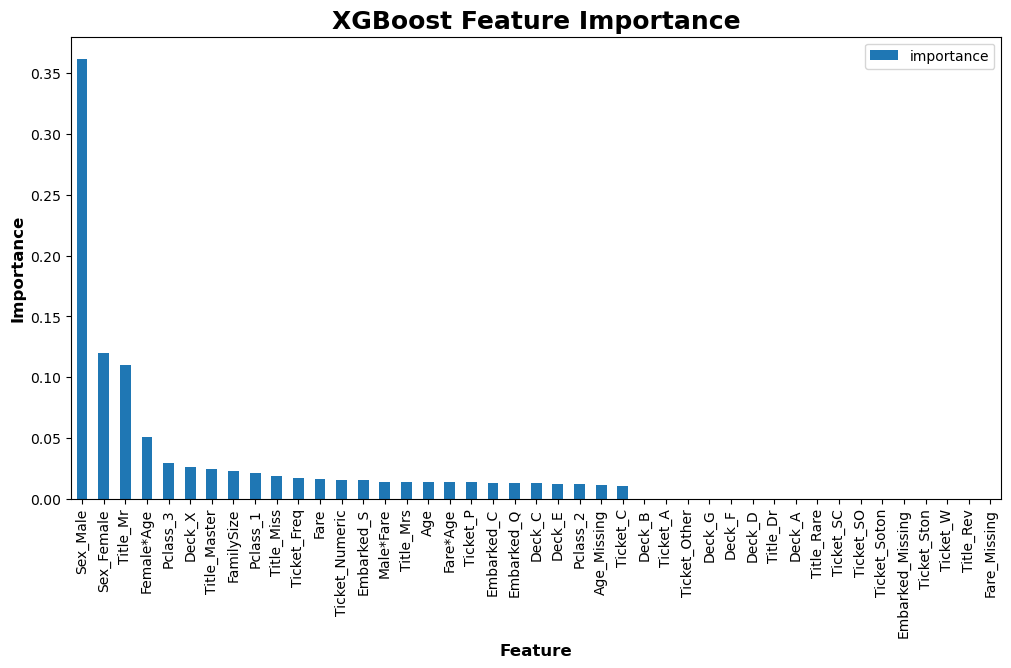

In [65]:
xgb_feature_imp = pd.DataFrame({'feature': X_train.columns, 
                                'importance': np.round(model_dict['XGBoost Hyper Tuned']['Model'].feature_importances_,3)})
xgb_feature_imp = xgb_feature_imp.sort_values('importance', ascending = False).set_index('feature')

f, ax = plt.subplots(figsize = (12, 6))
xgb_feature_imp.plot.bar(ax = ax)
plt.title('XGBoost Feature Importance', fontdict = plot_title_dict)
plt.ylabel('Importance', fontdict = plot_axis_dict)
plt.xlabel('Feature', fontdict = plot_axis_dict)
plt.show()

# 8. Calculate Model Probabilities

1. Narrow down initial list of models with best candidates
2. Calculate and store model probabilities
3. Evaluate Metrics

Metrics:
1. Confusion Matrix
2. Precision and Recall
3. F1 Score
4. ROC AUC Curve and Score

In [66]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score

In [67]:
final_options = ['Logistic Regression',
                 'Support Vector Machines',
                 'Random Forest Hyper Tuned',
                 'XGBoost Hyper Tuned']

for final_model in final_options:
    model_dict[final_model]['CV_Prob'] = cross_val_predict(model_dict[final_model]['Model'],
                                                           model_dict[final_model]['X_Train'],
                                                           Y_train,
                                                           cv = 10,
                                                           method = 'predict_proba')[:,1]
    model_dict[final_model]['Train_Prob'] = model_dict[final_model]['Model'].predict_proba(model_dict[final_model]['X_Train'])[:,1]
    model_dict[final_model]['Test_Prob'] = model_dict[final_model]['Model'].predict_proba(model_dict[final_model]['X_Test'])[:,1]

In [68]:
final_metrics_df = pd.DataFrame()
fpr_list = []
tpr_list = []
conf_mat_list = []
roc_auc_list = []
for final_model in final_options:
    
    # Confusion Matrix
    cv_preds = [int(float(p) > 0.5) for p in model_dict[final_model]['CV_Prob']]
    model_confusion_matrix = confusion_matrix(Y_train, cv_preds)
    conf_mat_list.append(model_confusion_matrix)
    true_non_surv = model_confusion_matrix[0][0]
    true_surv = model_confusion_matrix[1][1]

    # ROC Curve
    y_train_prob = model_dict[final_model]['Train_Prob']
    model_fpr, model_tpr, model_thresholds = roc_curve(Y_train, y_train_prob)
    fpr_list.append(model_fpr)
    tpr_list.append(model_tpr)
    model_roc_auc = roc_auc_score(Y_train, y_train_prob)
    roc_auc_list.append(model_roc_auc)

    # Metrics
    model_precision = precision_score(Y_train, cv_preds)
    model_recall = recall_score(Y_train, cv_preds)
    model_f1 = f1_score(Y_train, cv_preds)

    final_metrics_df = pd.concat([final_metrics_df,
                                  pd.DataFrame({'Selected Model': [final_model],
                                                'Precision': [round(model_precision * 100, 2)],
                                                'Recall': [round(model_recall * 100, 2)],
                                                'F1 Score': [round(model_f1 * 100, 2)],
                                                'ROC AUC': [round(model_roc_auc * 100, 2)], 
                                                'Non Survivors': true_non_surv,
                                                'Survivors': true_surv,
                                                'Total Correct': true_non_surv + true_surv
                                               })]).reset_index(drop = True)
final_metrics_df.sort_values(by = 'Precision', ascending = False)

,Selected Model,Precision,Recall,F1 Score,ROC AUC,Non Survivors,Survivors,Total Correct
1,Support Vector Machines,83.68,70.47,76.51,91.44,502,241,743
2,Random Forest Hyper Tuned,83.16,72.22,77.31,94.52,499,247,746
0,Logistic Regression,80.57,73.98,77.13,89.29,488,253,741
3,XGBoost Hyper Tuned,80.46,72.22,76.12,92.50,489,247,736


# 9. Create Ensemble Models

SVC good at predicting true non survivors, but other models good at predicting survivors. Explore ensembles

Cannot include Perceptron, Linear SVC, Stochastic Gradient Decent

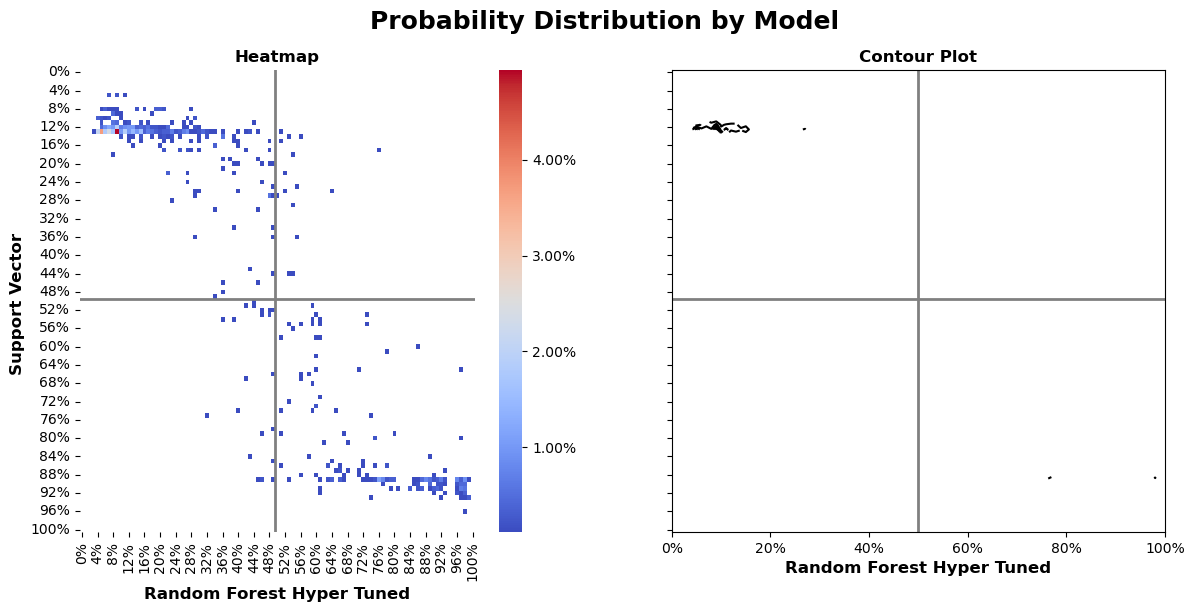

In [69]:
svc_train_prob_df = pd.DataFrame({'SVC': [round(p, 2) for p in model_dict['Support Vector Machines']['Train_Prob']]})
rfhp_train_prob_df = pd.DataFrame({'RF_HT': [round(p, 2) for p in model_dict['Random Forest Hyper Tuned']['Train_Prob']]})
svc_rfhp_heatmap_df = pd.concat([svc_train_prob_df, rfhp_train_prob_df], axis = 1)\
    .groupby(['SVC', 'RF_HT'], as_index = False)\
    .agg(Count = ('SVC', 'count'))
svc_rfhp_heatmap_df['Count'] = svc_rfhp_heatmap_df['Count'] / svc_rfhp_heatmap_df['Count'].sum()

x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
svc_rfhp_heatmap_df = pd.DataFrame({'SVC': x})\
    .merge(pd.DataFrame({'RF_HT': y}), how = 'cross')\
    .merge(svc_rfhp_heatmap_df, on = ['SVC', 'RF_HT'], how = 'left')\
    .pivot(index = 'SVC', columns = 'RF_HT', values = 'Count')

# Plots
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (14, 6))

# Heatmap
sns.heatmap(svc_rfhp_heatmap_df, cmap = 'coolwarm', cbar_kws = {'format': mtick.PercentFormatter(xmax = 1)},  ax = ax1)
ax1.set_title("Heatmap", fontdict = plot_axis_dict)
ax1.set_ylabel('Support Vector ', fontdict = plot_axis_dict)
ax1.set_xlabel('Random Forest Hyper Tuned', fontdict = plot_axis_dict)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 100))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 100))
ax1.axvline(x = 50, linewidth = 2, color = 'grey')
ax1.axhline(y = 50, linewidth = 2, color = 'grey')

# Contour
X, Y = np.meshgrid(x, y * 100)
Z = svc_rfhp_heatmap_df.to_numpy()
ax2.contour(X, Y, Z, colors = 'black')
ax2.set_title("Contour Plot", fontdict = plot_axis_dict)
ax2.set_ylabel('', fontdict = plot_axis_dict)
ax2.set_xlabel('Random Forest Hyper Tuned', fontdict = plot_axis_dict)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
ax2.axvline(x = 0.5, linewidth = 2, color = 'grey')
ax2.axhline(y = 50, linewidth = 2, color = 'grey')

plt.suptitle('Probability Distribution by Model', 
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.show()

In [70]:
# Function to create Ensemble models
def ensemble_model_fun(ensemble_name, ensemble_models, ensemble_weights):
    if sum(ensemble_weights) != 1:
        print('Model weights do not add to 100%')
    elif len(ensemble_models) == len(ensemble_weights):
        ensemble_name = ensemble_name + ' (' + ' - '.join(['{:.0%}'.format(w) for w in ensemble_weights]) + ')'
        ensemble_cv_prob = []
        ensemble_train_prob = []
        ensemble_test_prob = []
        for m, w in zip(ensemble_models, ensemble_weights):
            ensemble_cv_prob.append(model_dict[m]['CV_Prob'] * w)
            ensemble_train_prob.append(model_dict[m]['Train_Prob'] * w)
            ensemble_test_prob.append(model_dict[m]['Test_Prob'] * w)        
    else:
        print('Number of models does not match number of weights')
    return {'Model_Name': ensemble_name,
            'CV_Prob': np.sum(ensemble_cv_prob, axis = 0),
            'Train_Prob': np.sum(ensemble_train_prob, axis = 0),
            'Test_Prob': np.sum(ensemble_test_prob, axis = 0)}

In [71]:
ensemble_model = ensemble_model_fun('Ensemble: SVC + XGBoost Tuned',
                                    ['Support Vector Machines', 'XGBoost Hyper Tuned'],
                                    [0.5, 0.5])

final_options = final_options + [ensemble_model['Model_Name']]
model_dict[ensemble_model['Model_Name']] = {'CV_Prob': ensemble_model['CV_Prob'],
                                            'Train_Prob': ensemble_model['Train_Prob'],
                                            'Test_Prob': ensemble_model['Test_Prob']}
del ensemble_model

In [72]:
ensemble_model = ensemble_model_fun('Ensemble: SVC + Random Forest Tuned',
                                    ['Support Vector Machines', 'Random Forest Hyper Tuned'],
                                    [0.5, 0.5])

final_options = final_options + [ensemble_model['Model_Name']]
model_dict[ensemble_model['Model_Name']] = {'CV_Prob': ensemble_model['CV_Prob'],
                                            'Train_Prob': ensemble_model['Train_Prob'],
                                            'Test_Prob': ensemble_model['Test_Prob']}
del ensemble_model

In [73]:
ensemble_model = ensemble_model_fun('Ensemble: SVC + RF Tuned + XGBoost Tuned',
                                    ['Support Vector Machines', 'Random Forest Hyper Tuned', 'XGBoost Hyper Tuned'],
                                    [1/3, 1/3, 1/3])

final_options = final_options + [ensemble_model['Model_Name']]
model_dict[ensemble_model['Model_Name']] = {'CV_Prob': ensemble_model['CV_Prob'],
                                            'Train_Prob': ensemble_model['Train_Prob'],
                                            'Test_Prob': ensemble_model['Test_Prob']}
del ensemble_model

In [74]:
ensemble_model = ensemble_model_fun('Ensemble: SVC + Logistic Regression',
                                    ['Support Vector Machines', 'Logistic Regression'],
                                    [0.5, 0.5])

final_options = final_options + [ensemble_model['Model_Name']]
model_dict[ensemble_model['Model_Name']] = {'CV_Prob': ensemble_model['CV_Prob'],
                                            'Train_Prob': ensemble_model['Train_Prob'],
                                            'Test_Prob': ensemble_model['Test_Prob']}
del ensemble_model

In [75]:
final_options

['Logistic Regression',
 'Support Vector Machines',
 'Random Forest Hyper Tuned',
 'XGBoost Hyper Tuned',
 'Ensemble: SVC + XGBoost Tuned (50% - 50%)',
 'Ensemble: SVC + Random Forest Tuned (50% - 50%)',
 'Ensemble: SVC + RF Tuned + XGBoost Tuned (33% - 33% - 33%)',
 'Ensemble: SVC + Logistic Regression (50% - 50%)']

# 10. Calculate Model Performance Metrics

Re-evaluate metrics with ensemble models.

Metrics:
1. Confusion Matrix
2. Precision and Recall
3. F1 Score
4. ROC AUC Curve and Score

In [76]:
final_metrics_df = pd.DataFrame()
fpr_list = []
tpr_list = []
conf_mat_list = []
roc_auc_list = []
for final_model in final_options:
    
    # Confusion Matrix
    cv_preds = [int(float(p) > 0.5) for p in model_dict[final_model]['CV_Prob']]
    model_confusion_matrix = confusion_matrix(Y_train, cv_preds)
    conf_mat_list.append(model_confusion_matrix)
    true_non_surv = model_confusion_matrix[0][0]
    true_surv = model_confusion_matrix[1][1]

    # ROC Curve
    y_train_prob = model_dict[final_model]['Train_Prob']
    model_fpr, model_tpr, model_thresholds = roc_curve(Y_train, y_train_prob)
    fpr_list.append(model_fpr)
    tpr_list.append(model_tpr)
    model_roc_auc = roc_auc_score(Y_train, y_train_prob)
    roc_auc_list.append(model_roc_auc)

    # Metrics
    model_precision = precision_score(Y_train, cv_preds)
    model_recall = recall_score(Y_train, cv_preds)
    model_f1 = f1_score(Y_train, cv_preds)

    final_metrics_df = pd.concat([final_metrics_df,
                                  pd.DataFrame({'Selected Model': [final_model],
                                                'Precision': [round(model_precision * 100, 2)],
                                                'Recall': [round(model_recall * 100, 2)],
                                                'F1 Score': [round(model_f1 * 100, 2)],
                                                'ROC AUC': [round(model_roc_auc * 100, 2)], 
                                                'Non Survivors': true_non_surv,
                                                'Survivors': true_surv,
                                                'Total Correct': true_non_surv + true_surv
                                               })]).reset_index(drop = True)

In [77]:
final_metrics_df.sort_values(by = 'Precision', ascending = False)

,Selected Model,Precision,Recall,F1 Score,ROC AUC,Non Survivors,Survivors,Total Correct
5,Ensemble: SVC + Random Forest Tuned (50% - 50%),84.80,73.39,78.68,94.41,504,251,755
1,Support Vector Machines,83.68,70.47,76.51,91.44,502,241,743
4,Ensemble: SVC + XGBoost Tuned (50% - 50%),83.44,73.68,78.26,93.00,499,252,751
6,Ensemble: SVC + RF Tuned + XGBoost Tuned (33% ...,83.44,73.68,78.26,94.03,499,252,751
2,Random Forest Hyper Tuned,83.16,72.22,77.31,94.52,499,247,746
7,Ensemble: SVC + Logistic Regression (50% - 50%),82.03,73.39,77.47,90.80,494,251,745
0,Logistic Regression,80.57,73.98,77.13,89.29,488,253,741
3,XGBoost Hyper Tuned,80.46,72.22,76.12,92.50,489,247,736


In [78]:
if kaggle_env == False:
    print(pd.read_pickle(kaggle_path + '/baseline/final_metrics').sort_values(by = 'Precision', ascending = False))

              Selected Model  Precision  Recall  F1 Score  ROC AUC  \
1    Support Vector Machines      83.10   70.47     76.27    91.38   
2  Random Forest Hyper Tuned      81.25   72.22     76.47    92.42   
3        XGBoost Hyper Tuned      79.50   74.85     77.11    95.56   
0        Logistic Regression      79.26   74.85     76.99    89.18   

   Non Survivors  Survivors  Total Correct  
1            500        241            741  
2            492        247            739  
3            483        256            739  
0            482        256            738  


In [79]:
# # Save for comp
# final_metrics_df.to_pickle(kaggle_path + '/baseline/final_metrics')

# 11. Select Final Model

Combining SVC and Random Forest scores highest across both precision and recall and also has the highest F1 score.

In [80]:
selection = 5

final_model = final_options[selection]
print('Selected Model: ' + final_model)
Y_test_prob = model_dict[final_model]['Test_Prob']
submission_df = pd.DataFrame({"PassengerId": test_df["PassengerId"],
                              "Survived": [int(float(p) > 0.5) for p in Y_test_prob]})
submission_df

Selected Model: Ensemble: SVC + Random Forest Tuned (50% - 50%)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


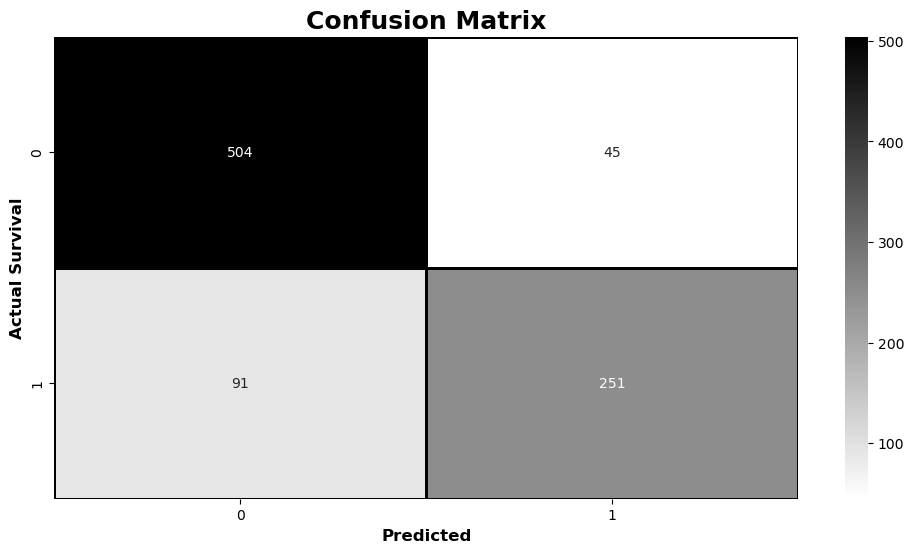

In [81]:
f, ax = plt.subplots(figsize = (12, 6))

sns.heatmap(conf_mat_list[selection],
            annot = True,
            fmt = ',.0f',
            cmap = 'binary',
            linewidths = 1, 
            linecolor = 'black',
            cbar_kws = {'format': mtick.StrMethodFormatter('{x:,.0f}')},
            ax = ax)
plt.title('Confusion Matrix', fontdict = plot_title_dict)
plt.ylabel('Actual Survival', fontdict = plot_axis_dict)
plt.xlabel('Predicted', fontdict = plot_axis_dict)
plt.show()

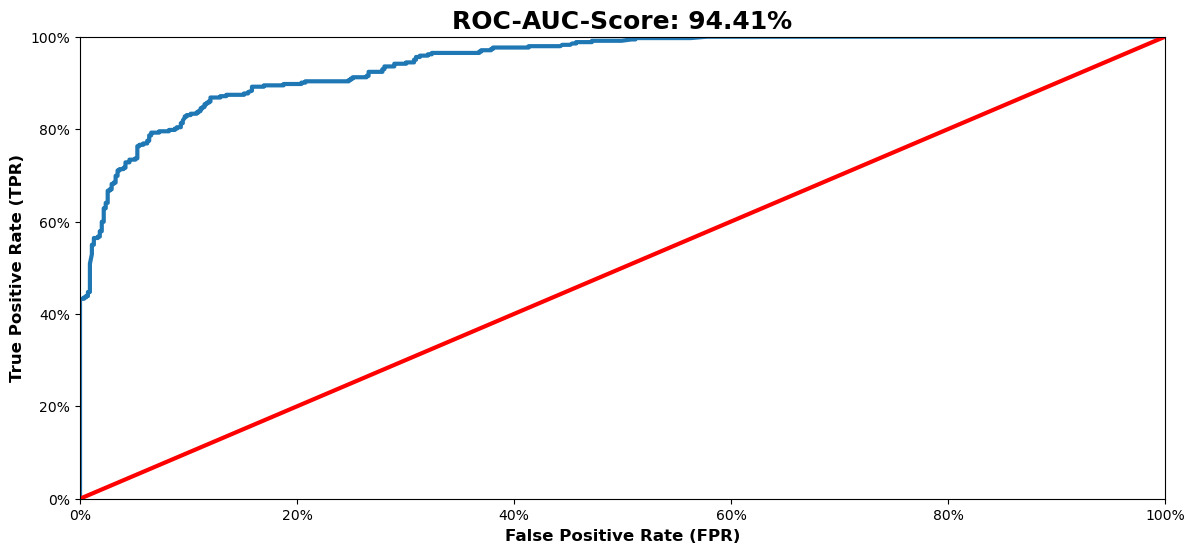

In [82]:
f, ax = plt.subplots(figsize = (14, 6))
plt.plot(fpr_list[selection], 
         tpr_list[selection], 
         linewidth = 3, label = None)
plt.plot([0, 1], [0, 1], 'r', linewidth = 3)
plt.axis([0, 1, 0, 1])
plt.title('ROC-AUC-Score: ' +"{:.2%}".format(roc_auc_list[selection]), fontdict = plot_title_dict)
plt.xlabel('False Positive Rate (FPR)', fontdict = plot_axis_dict)
plt.ylabel('True Positive Rate (TPR)', fontdict = plot_axis_dict)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.show()

# 12. Submit to Kaggle

References:
1. https://www.kaggle.com/docs/api
2. https://www.youtube.com/watch?v=gkEbaMgvLs8

In [83]:
print('Selected Model: ' + final_model)
print('Make sure to update comment on submission')
submission_df.to_csv('submission.csv', index = False)

Selected Model: Ensemble: SVC + Random Forest Tuned (50% - 50%)
Make sure to update comment on submission


In [84]:
# !kaggle competitions submit -c titanic -f submission.csv -m svc_rft

# 13. Compare Public Score with Leaderboard

Public Scores:
1. Support Vector Machines: **0.79186**
2. Random Forest Hyper Tuned: **0.78229**
4. Ensemble: SVC + Random Forest Tuned (50% - 50%): **0.78468**

Public score: 78.468%
Mean score: 77.305%
Median score: 77.511%
11.8% are better
88.2% are equal or worse
Out of 15,448 scores, 1,819 scored higher.


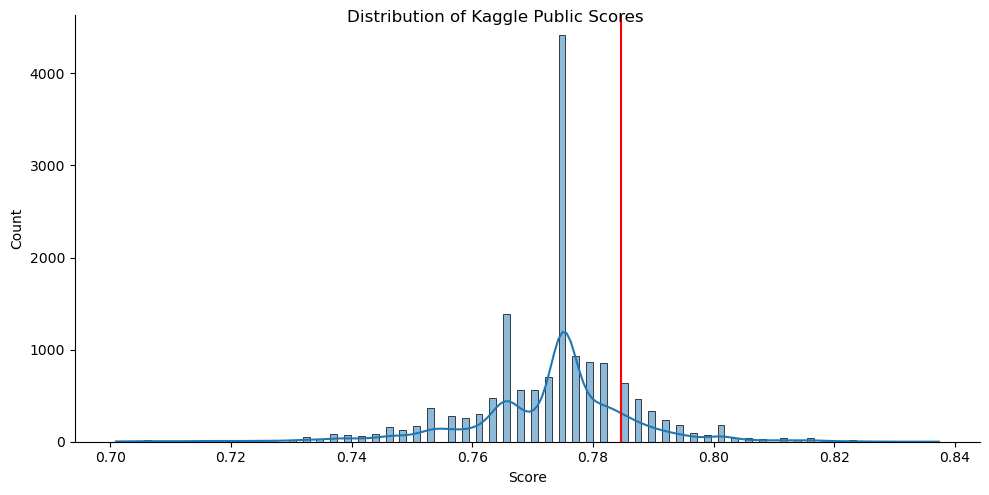

In [85]:
public_score = 0.78468

scores_df = pd.read_csv(kaggle_path + '/titanic-leaderboard/titanic-publicleaderboard-2025-11-28T01-56-53.csv')
scores_df = scores_df[(scores_df['Score'] >= 0.70) & (scores_df['Score'] <= 0.85)].reset_index(drop = True)

total_scores = scores_df.shape[0]
better_scores = scores_df[scores_df['Score'] > public_score].shape[0]
worse_scores = scores_df[scores_df['Score'] <= public_score].shape[0]
score_pct = better_scores / total_scores

print('Public score: ' + "{:.3%}".format(public_score))
print('Mean score: ' + "{:.3%}".format(scores_df['Score'].mean()))
print('Median score: ' + "{:.3%}".format(scores_df['Score'].median()))
print("{:.1%}".format(better_scores / total_scores) + ' are better')
print("{:.1%}".format(worse_scores / total_scores) + ' are equal or worse')
print('Out of ' + "{:,}".format(total_scores) + ' scores, ' + "{:,}".format(better_scores) + ' scored higher.')

sns.displot(data = scores_df, 
            x = 'Score', 
            kde = True,
            height = 5,
            aspect = 2)
plt.axvline(x = public_score, color = 'red')
plt.suptitle('Distribution of Kaggle Public Scores')
plt.show()